*Used to remove the toolbar:*

In [1]:
%%javascript
$('#menubar').toggle();

<IPython.core.display.Javascript object>

---

# Introduction to Data Science and Systems 2023-2024

## Week 4: Optimisation I 
\- Parameters, objective functions, classification of optimisation problems

##### University of Glasgow - material prepared by John H. Williamson (adapted to IDSS by NP), <small>v20232024a</small>
----

# Summary
By the end of this unit you should know:
* what an objective function, constraint function and a parameter vector is in the context of optimisation
* how to play the piano
* the difference between discrete and continuous optimisation
* convex and nonconvex optimisation and how to recognise them
* what constrained optimisation is and the difference between soft and hard constraints
* key properties of objective functions, including convexity and continuity
* basic uses of optimisation and how to come up with objective functions
* what linear least squares is
* how iterative optimisation works
* the principles of heuristic optimisation
* the properties of random search, with the metaheuristics: locality, memory, temperature and population

In [2]:
import IPython.display
IPython.display.HTML("""
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>""")

In [3]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl

import scipy.optimize    # scipy's optimisation routines
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)

# Example: a synthesizer
<img src="imgs/oxefm.png">

# Introduction to optimisation

## What is optimisation?
**Optimisation** is the process of adjusting things to make them better. In computer science, we want to do this *automatically* by a algorithm. An enormous number of problems can be framed as optimisation, and there are a plethora of algorithms which can then do the automatic adjustment *efficiently*, in that they find the best adjustments in few steps. In this sense, *optimisation is search*, and optimisation algorithms search efficiently using mathematical structure of the problem space.

Optimisation is at the heart of machine learning; it is a critical part of all kinds of manufacturing and industrial processes, from shipbuilding to circuit design; it can even be used to [automatically make scatterplot graphs easier to read](http://userinterfaces.aalto.fi/scatterplot_optimization/).

### One algorithm to rule them all: no special cases
Optimisation algorithms allow us to apply *standard algorithms* to an enormous number of problems. We don't have special cases for every specific problem; instead we formulate the problems so that generic algorithms can solve them. As a consequence, to apply optimisation algorithms, the problems must be specified formally. There is a real art in specifying problems so that optimisation can tackle them.

> What is often called "artificial intelligence" often comes down to optimisation. With optimisation  we can specify problems, instead of solutions.

---

## Parameters and objective function


<img src="imgs/synth.png" width="50%">

*Image credit: derived from](https://flickr.com/photos/doctorow/14638932732 "Enticingly technical synthesizer 1, Control Voltage, Mississippi Street, Portland, Oregon, USA") by [gruntzooki](https://flickr.com/people/doctorow) [CC (BY-SA)](https://creativecommons.org/licenses/by-sa/2.0/)*


There are two parts to an optimisation problem:

* **parameters**: the things we can adjust, which might be a scalar or vector or other array of values, denoted $\theta$. The parameters exist in a **parameter space** -- the set of all possible configurations of parameters denoted $\Theta$. This space is often a **vector space** like $\real^n$, but doesn't need to be. For example, the set of all knob/slider positions on the synthesizer panel above could be considered points in a subset of a vector space. If the parameters do lie in a vector space, we talk about the **parameter vector** $\theta$.


* **the objective function**: a function that maps the parameters onto a *single numerical measure* of how good the configuration is. $L(\theta)$.  The output of the objective function is a single scalar. The objective function is sometimes called the *loss function*, the *cost function*, *fitness function*, *utility function*, *energy surface*, all of which refer to (roughly) the same concept. It is a quantitative ("objective") measure of "goodness".

*The desired output of the optimisation algorithm is the parameter configuration that minimises the objective function.*

Writing this mathematically, this is the $\argmin$ (the argument that produces the minimum value) of the objective function:

<div class="alert alert-box alert-success">
$$\theta^* = \argmin_{\theta\in\Theta} L(\theta) $$
</div>

* $\theta^*$ is the configuration that we want to find; the one for which the objective function is lowest. 
* $\Theta$ is the set of all possible configurations that $\theta$ could take on, e.g. $\real^N$. 

Most optimisation problems have one more component:

* **constraints**: the limitations on the parameters. This defines a region of the parameter space that is feasible, the **feasible set** or **feasible region**. For example, the synthesizer above has knobs with a fixed physical range, say 0-10; it isn't possible to turn them up to 11. Most optimisation problems have constraints of some kind; 

> "design a plane *(adjust parameters)* that flies as fast as possible *(objective function)*, and costs less than `$180M` *(constraints)*.

We usually think of the objective function as a **cost** which is *minimised*. Any maximisation problem can be reframed as a minimisation problem by a simple switch of sign, so this does not lose generality. If if we wanted to optimise the knob settings on our synthesizer to make a really good piano sound ("maximise goodness"), we could instead frame this as a problem of minimising the difference between the sound produced and the sound of a piano. We would, of course, need to have a **precise** way of measuring this difference; one that results in a single real number measure of cost.

<img src="imgs/objective_fn.png">

---

### Minimising differences
As in this example, it is common to have express problems in a form where the objective function is a  **distance between an output and a reference is measured**. Not every objective function has this form, but many do.

That is, we have some function $y^\prime = f(\vec{x};\theta)$ that produces an output from an input $\vec{x}$ governed by a set of parameters $\theta$, and we measure the difference between the output and some reference $y$ (e.g. using a vector norm):

<div class="alert alert-box alert-success">
$$ \ L(\theta) = \|y^\prime - y\| = \|f(\vec{x};\theta) - y\| $$
    </div>

This is very common in **approximation problems**, where we want to find a function that approximates a set of measured observations. This is the core problem of machine learning.

Note that the notation $f(\vec{x};\theta)$ just means that the output of $f$ depends both on some (vector) input $\vec{x}$ and on a parameter vector $\theta$. Optimisation only ever adjusts $\theta$, and the vector $\vec{x}$ is considered fixed during optimisation (it might, for example, represent a collection of real-world measurements). In the synthesizer example, $\vec{x}$ might represent the keys pressed, which affect the sound but we *do not* optimise; while $\vec{\theta}$ represents the knob settings which affect that sound and we do optimise.

### Evaluating the objective function
It may be **expensive** to evaluate the objective function. For example:
* the computation might take a long time (invert a 10000x10000 matrix);
* or it might require a real-world experiment to be performed (do the users like the new app layout?);
* or it might be dangerous (which wire on the bomb should I cut next?);
* or it might require data that must be bought and paid for (literally expensive). 

In all cases, it will take some computational power to evaluate the objective function, and therefore will have a time cost.

This means that a *good* optimisation algorithm will find the optimal configuration of parameters with few queries (evaluations of the objective function). To do this, there must be mathematical **structure** which can help guide the search. Without any structure at all, the best that could be done would be to randomly guess parameter configurations and choose the lowest cost configuration after some number of iterations. This isn't typically a feasible approach.






## Discrete vs. continuous
If the parameters are in a continuous space (typically $\mathbb{R^n}$), the problem is one of **continuous optimization**; if the parameters are discrete, the problem is **discrete optimization**. Continuous optimisation is usually easier because we can exploit the concept of **smoothness** and **continuity**.

### Properties of optimisation

Every optimisation problem has two parts:
* **Parameters**, the things that can be adjusted.
* **Objective function**, which measures how good a particular set of parameters are.

An optimisation problem usually also has:
* **Constraints**, that define the feasible set of parameters.

The **objective function** is a function *of the parameters* which returns a *single scalar value*, representing how good that parameter set is. 

## Throwing a stone

For example, if I wanted to optimise how far I could throw a stone, I might be able to adjust the throwing angle. This is the *parameter* I could tweak (just one parameter $\theta=[\alpha]$, in this case). 

The objective function must be a function which depends on this parameter. I would have to *simulate* throwing the ball to work out how far it went and try and make it go further and further.

In [4]:
import numpy as np

def L(theta):
    # L *must* depend on the parameters I can adjust
    # in this case, there is only one; the throw angle

    # pull out the angle, convert from degrees to radians
    angle = np.radians(theta[0])

    # initial throw position x=0m, y=1m
    pos = np.array([0.0, 1.0])

    # initial throw velocity, depends on angle
    vel = np.array([np.cos(angle), np.sin(angle)])

    posns = []
    # simulate throwing the ball, until it hits the ground
    while pos[1] >= 0:
        pos += vel
        vel[1] -= 0.005  # gravity
        vel -= 0.01 * vel  # air resistance
        posns.append(list(pos))
    posns = np.array(posns)

    plt.gca().plot(posns[:, 0], posns[:, 1], "k", lw=0.1)

    # return how far our throw went
    # remember that we want to minimise
    # our objective function, so this value
    # must get *lower* as our throw gets longer

    return -np.abs(pos[0])

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -70.14102701610933
             x: [ 3.085e+01]
           nit: 24
          nfev: 50
 final_simplex: (array([[ 3.085e+01],
                       [ 3.085e+01]]), array([-7.014e+01, -7.014e+01]))


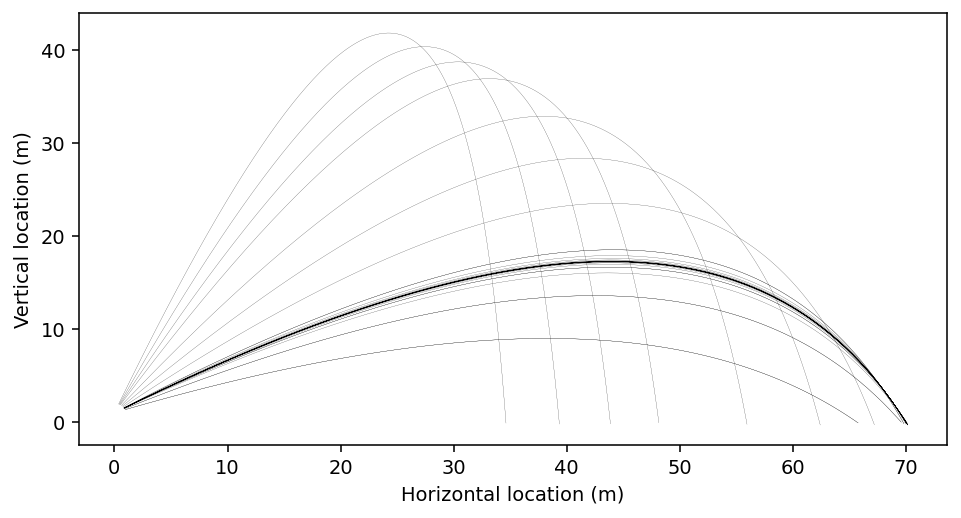

In [5]:
import scipy.optimize

fig, ax = plt.subplots()
ax.set_xlabel("Horizontal location (m)")
ax.set_ylabel("Vertical location (m)")
# use a built in optimiser to solve this
res = scipy.optimize.minimize(L, [65.0], method="nelder-mead")
print(res)

We will get a result that throwing the ball at around 30 degrees to the horizontal will give the longest throw. Note that the answer will only be 45 degrees if there is no air resistance; something that would be annoying to work out but is trivial to optimise for. If air resistance is higher, then the throw should be more horizontal.

### Focus: continuous optimisation in real vector spaces
This course will focus on optimisation of continuous problems in $\real^n$. That is $$\theta \in \real^n = [\theta_1, \theta_2, \dots, \theta_n],$$ and the optimisation problem is one of:

$$\theta^* = \argmin_{\theta \in \real^n} L(\theta), \text{subject to constraints}$$

This it the problem of searching a continuous vector space to find the point where $L(\theta)$ is smallest. We will typically encounter problems where the objective function is *smooth* and *continuous* in this vector space; note that the parameters being elements of a continuous space does not necessarily imply that the objective function is continuous in that space.

Some optimisation algorithms are **iterative**, in that they generate successively better approximations to a solution. Other methods are **direct**, like linear least squares (which we'll briefly discuss), and involving finding a minimum exactly in one step. We will focus primarily on **iterative, approximate** optimisation in this course.

#### A function of space
The objective function maps points in space to values; i.e. it defines a curve/surface/density/etc. which varies across space. We want to find, as quickly as possible, a point in space where this is as small as possible, without going through any "walls" we have defined via constraints.





### Geometric median: optimisation in  $\real^2$

* **Problem** Find the median of a `>1D` dataset. The standard median is computed by sorting and then selecting the middle element (with various rules for even sized datasets). This doesn't work for higher dimensions, and there is no straightforward direct algorithm. But there is an easy definition of the median: it is the vector that minimises the sum of distances to all vectors in the dataset.

A very simple optimisation example is to find a point that minimises the distance to a collection of other points (with respect to some norm).  We can define:

* **parameters** $\theta=[x, y\dots]$, a position  in 2D. 
* **objective function** the sum of distances between a point and a collection of target points $\vec{x_i}$:
$$
L(\theta) = \sum_i ||\theta - \vec{x_i}||_2
$$

This will try and find a point in space (represented as $\theta$) which minimises the distances to the target points. We can solve this, starting from some random initial condition (guess for $\theta$):

In [6]:
# some random points
targets = np.random.normal(0,1,(50,2)) + np.array([0.5, -1])

# This is the objective function
def loss(x):             
    # how far are we away from being minimal distance to every point?
    return np.sum(np.linalg.norm(x[:,None] -
                                 targets.T, axis=1, 
                                 ord=np.inf))

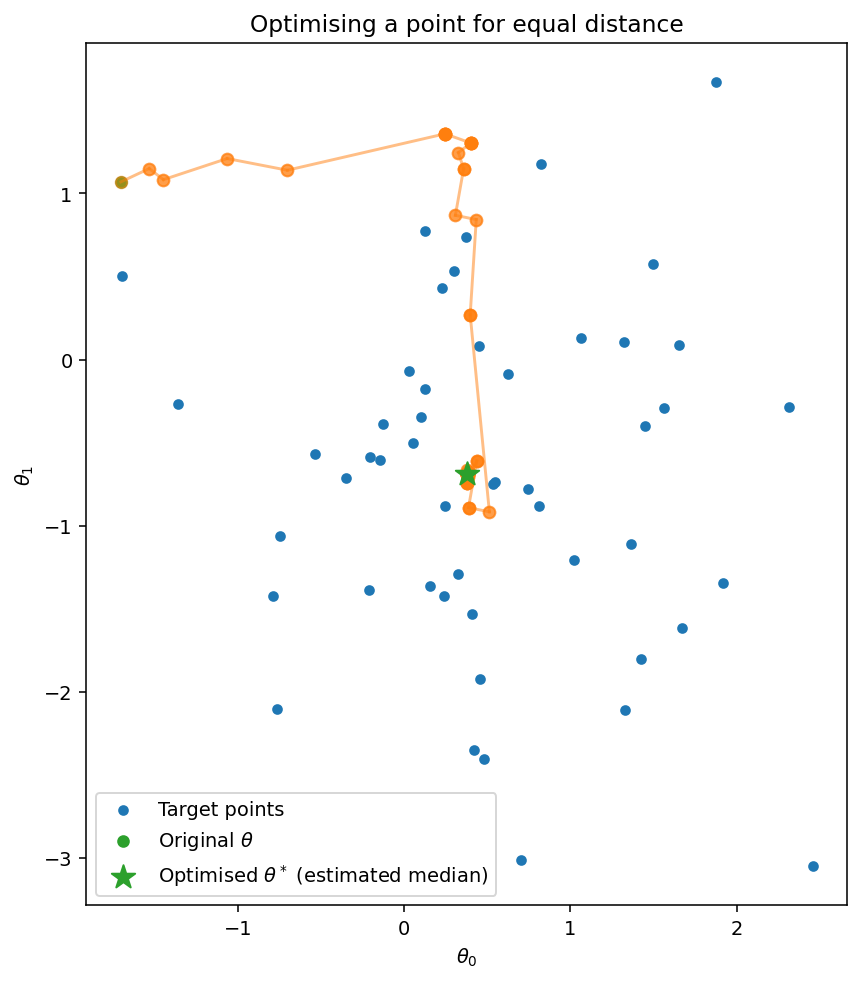

In [7]:
    
# Initial state -- guess for theta
theta = np.random.uniform(-2, 2, 2) # 64 random 2D points

# Plot the original data
################
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(targets[:,0], targets[:,1], c='C0', s=20, label="Target points", alpha=1.0)
ax.scatter(theta[0], theta[1], c='C2', s=30, label="Original $\\theta$", alpha=1.0)
ax.set_xlabel("$\\theta_0$")
ax.set_ylabel("$\\theta_1$")
last_theta = theta

def plot_intermediate(x):    
        ax.plot([last_theta[0], x[0]], [last_theta[1], x[1]], c='C1',alpha=0.5, marker='o')
        last_theta[:] = x # hack to show a history
##################
    
# minimise the loss using a standard optimizer
result = scipy.optimize.minimize(loss, theta.ravel(), method='Nelder-Mead', callback=plot_intermediate, )

###########
# plot the final positions
ax.scatter(result.x[0], result.x[1], c='C2', s=160, marker='*', label="Optimised $\\theta^*$ (estimated median)", zorder=100)
ax.set_title("Optimising a point for equal distance")
ax.legend()
ax.set_aspect(1.0)
###########

Text(0.5, 0.92, 'Objective function as a function of the parameters')

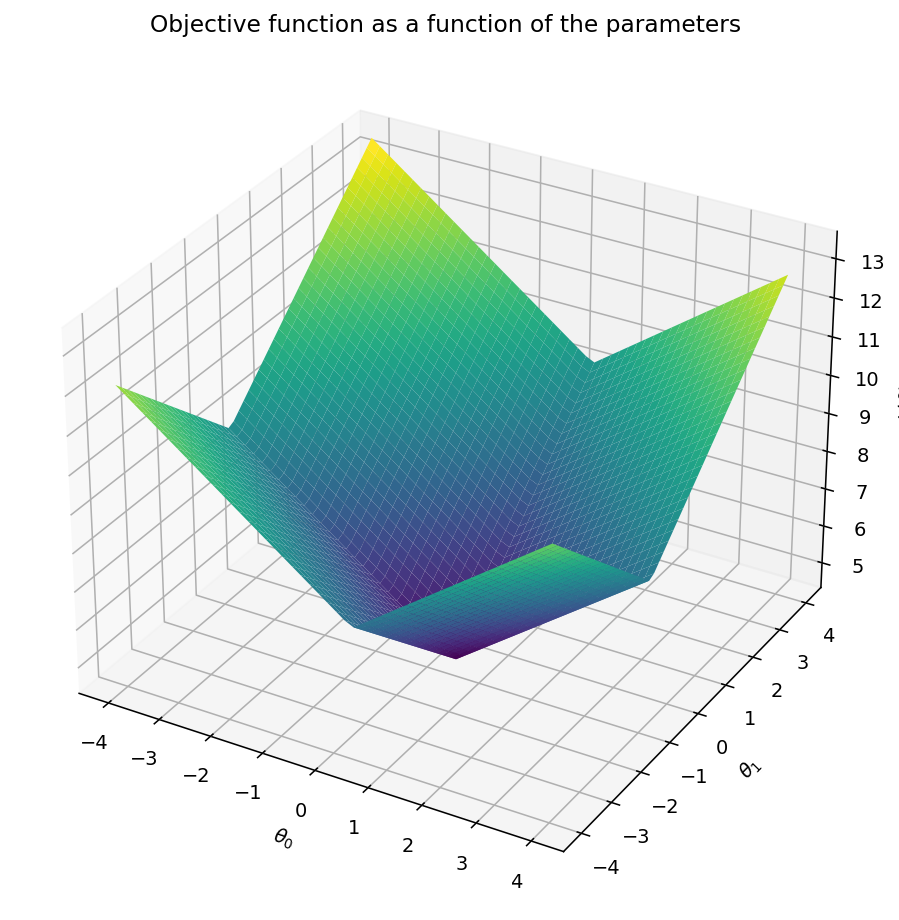

In [8]:
## Show the objective function as a function of parameters
space = np.linspace(-4,4,50)
xm, ym = np.meshgrid(space, space)
pts = np.stack([xm.ravel(), ym.ravel()]).T
zm = []

# compute the objective function at a grid
# of different parameter values
for pt in pts:
    zm.append(loss(pt))
%matplotlib inline

## plot in 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
zm = np.array(zm).reshape(xm.shape)
ax.plot_surface(xm,ym,zm,cmap='viridis')
ax.set_zlabel("$L(\\theta)$")
ax.set_xlabel("$\\theta_0$")
ax.set_ylabel("$\\theta_1$")
ax.set_title("Objective function as a function of the parameters")              


### An example of optimisation in $\real^N$
We can work in higher dimensions just as easily. A slightly different problem is to try and find a layout of points in such that the points are **evenly spaced** (with respect to some norm). In this case we have to optimise a whole collection of points, which we can do by rolling them all up into a single parameter vector.

We can define:

* **parameters** $\theta=[x_1, y_1, x_2, y_2, \dots]$, an array of positions of points in 2D. Note: we have "unpacked" a sequence of 2D points into a higher dimensional vector, so that a *whole configuration* of points is a single point in a vector space.
* **loss function** the sum of squares of differences between the Euclidean pairwise distances between points and some target distance:
$$
\sum_i \sum_j (\alpha - ||x_i - x_j||_2)^2
$$
This will try and find a configuration of points that are all $\alpha$ units apart.

We again start from some random initial condition, with 64 2D points; a 128 dimensional $\theta$.

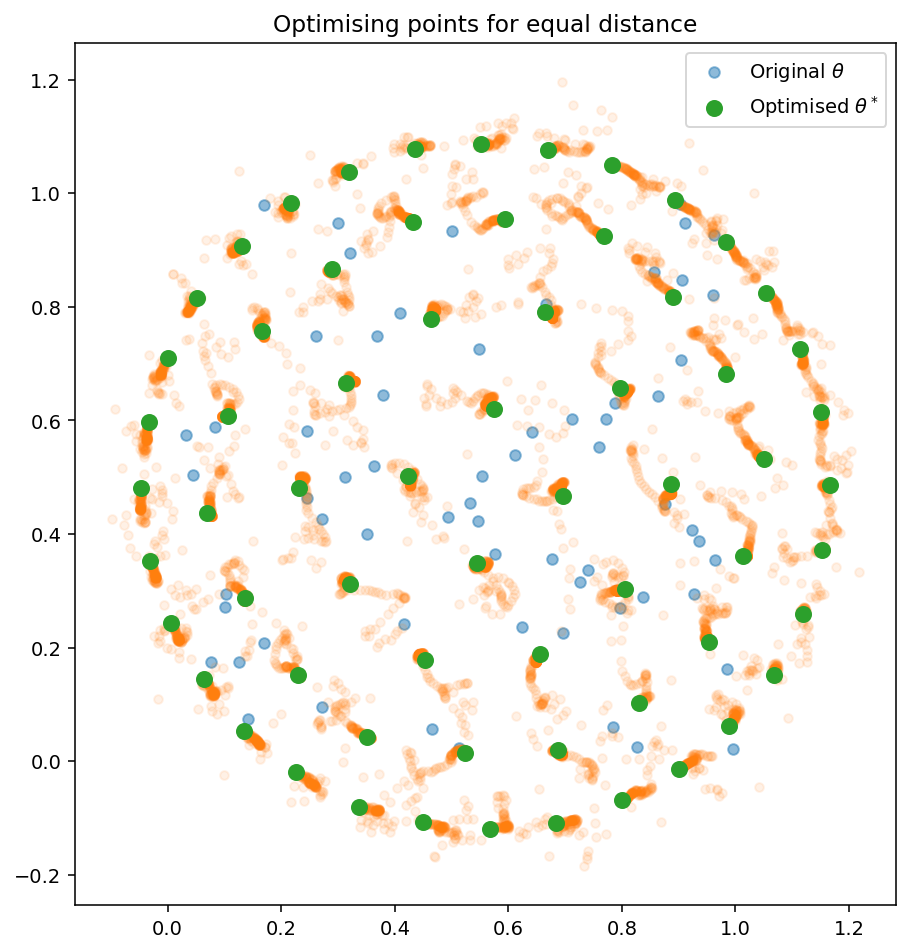

In [9]:
# This is the objective function
# How far are we away from optimality?
def loss(x):
    # reshape back to the original shape
    x = x.reshape(theta.shape)    
    distances = np.linalg.norm(x[:,:,None] - x[:,:,None].T, axis=1, ord=2)        
    # compute difference between pairwise distance and 0.8
    return np.sum((0.8-distances)**2) 

# Initial state -- guess for theta
theta = np.random.uniform(0, 1, (64,2)) # 64 random 2D points

# Plot the original data
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(theta[:,0], theta[:,1], c='C0', s=30, label="Original $\\theta$", alpha=0.5)

def plot_intermediate(x):
    theta_star = x.reshape(theta.shape)    
    ax.scatter(theta_star[:,0], theta_star[:,1], c='C1', s=20, alpha=0.1)

# minimise the loss (we have to convert to a 1D array for minimize() to work)
result = scipy.optimize.minimize(loss, theta.ravel(), method='BFGS', callback=plot_intermediate)

# reshape the result back to an array 
theta_star = result.x.reshape(theta.shape)

# plot the final positions
ax.scatter(theta_star[:,0], theta_star[:,1], c='C2', s=60, label="Optimised $\\theta^*$")
ax.set_title("Optimising points for equal distance")
ax.legend()
ax.set_aspect(1.0)


# Constrained optimisation

If a problem has constraints on the parameters beyond purely minimising the objective function then the problem is **constrained optimisation**.  For example, in the synthesizer above, it's not much use if the optimal solution requires one the knobs to be turned to an impossible value; the parameter space is limited in extent on every dimension. This limits the **feasible set** of the parameters.


<div class="alert alert-success alert-box">
A constrained optimisation might be written in terms of an equality constraint:    
$$ \theta^* = \argmin_{\theta\in\Theta} L(\theta) \text{ subject to } c(\theta)=0,$$
or an inequality:
$$ \theta^* = \argmin_{\theta\in\Theta} L(\theta) \text{ subject to } c(\theta)\leq0,$$
where $c(\theta)$ is a function that represents the constraints.

</div>

* An **equality** constraint can be thought of as constraining the parameters to a *surface*, to represent a tradeoff. For example, $c(\theta) =\|\theta\|_2-1$  forces the parameters to lie on the surface of a unit sphere. An equality constraint might be used when trading off items where the total value must remain unchanged (e.g. the payload weight in a satellite might be fixed in advance).

* An **inequality** constraint can be thought of as constraining the parameters to a *volume*, to represent bounds on the values. For example, $c(\theta) =\|\theta\|_\infty-10$  forces the parameters to lie within a box extending (-10, 10) around the origin -- perhaps the range of the knobs on the synthesizer.

#### Common constraint types

A **box constraint** is a simple kind of constraint, and is just a requirement that $\theta$ lie within a box inside $R^n$; for example, that every element $0<\theta_i<1$ (all parameters in the positive unit cube) or $\theta_i>0$ (all parameters in the positive **orthant**). This is an inequality constraint with a simple form of $c(\vec{\theta})$. Many optimisation algorithms support box constraints.

<img src="imgs/peaks.png">

A **convex constraint** is another simple kind of constraint, where the constraint is a collection of inequalities on a convex sum of the parameters $\theta$. Box constraints are a specific subclass of convex constraints. This is equivalent to the feasible set being limited by the intersection of many of **planes/hyperplanes** (possibly an infinite number in the case of curved convex constraints).

**Unconstrained optimization** does not apply any constraints to the parameters, and any parameter configuration in the search space is possible. In many problems, pure unconstrained optimisation will lead to unhelpful results ("the airplane will get the best lift if the wing is two hundred miles long" -- which might be true but impossible to construct).


## Constraints and penalties
Unconstrained optimisation rarely gives useful answers on its own. Consider the example of the airfoil. Increasing lift might be achieved by making the airfoil length longer and longer. At some point, this might become physically impossible to build.

Although we often represent $\theta$ as being in $\real^N$, the feasible set is typically not the entire vector space. There are two approaches to deal with this:

#### Constrained optimisation
* Use an optimisation algorithm that supports hard constraints inherently. This is straightforward for certain kinds of optimisation, but trickier for general optimisation.Typically constraints will be specified as either a **convex region** or a simple (hyper)rectangular region of the space (a **box constraint**).
* **Pros**: 
    * Guarantees that solution will satisfy constraints.
    * May be able to use constraints to speed up optimisation.
* **Cons**: 
    * may be less efficient than unconstrained optimization. 
    * Fewer algorithms available for optimisation.
    * may be hard to specify feasible region with the parameters available in the optimiser.

#### Soft constraints
* Apply penalties to the objective function to "discourage" solutions that violate the constraints. This is particularly appropriate if the constraints really are soft (it doesn't perhaps matter if the maximum airfoil length is 1.5m or 1.6m, but it can't be 10m). In this case, the penalties are just terms added to the objective function. The optimiser stays the same, but the objective function is modified.

$$L(\theta^\prime) = L(\theta) + \lambda(\theta),$$ where $\lambda(\theta)$ is a **penalty function** with an increasing value as the constraints are more egregiously violated.

* **Pros**
    * any optimiser can be used
    * can deal with *soft* constraints sensibly
* **Cons:** 
    * may not respect important constraints, particularly if they are very sharp
    * can be hard to formulate constraints as penalties
    * cannot take advantage of efficient search in constrained regions of space

<img src="imgs/soft_constraints.png">

## 	Relaxation of objective functions
It can be much harder to solve discrete optimization and constrained optimization problems efficiently; some algorithms try and find similar continuous or unconstrained optimization problems to solve instead. This is called **relaxation**; a **relaxed** version of the problem is solved instead of the original hard optimization problem. For example, sometimes the constraints in a problem can be absorbed into the objective function, to convert a constrained problem to an unconstrained problem. 

### Penalisation
**Penalisation** refers to terms which augment an objective function to minimise some other property of the solution, typically to approximate constrained optimisation.  This is widely used in approximation problems to find solutions that **generalise well**; that is which are tuned to approximate some data, but not *too* closely.

This is a relaxation of a problem with hard constraints (which needs specialised algorithms) to a problem with a simple objective function which works with any objective function. If you have encountered **Lagrange multipliers** before, these are an example of a relaxation of hard constraints to penalty terms.



### Penalty functions
A **penalty function** is just a term added to an objective function which will disfavour "bad solutions". 

We can return to the stone throwing example, and extend our model. Say
I can control the angle of a stone throw; perhaps I can also control how hard I throw it. But there is a maximum limit to my strength. This is a constraint (an inequality constraint, which limits the maximum value of the strength parameter).

* Objective function: how far away does the stone land? $L(\theta) = \mathrm{throw_distance}(\theta)$
* Parameters: angle of the throw $\alpha$ and strength of the throw $v$ (exit velocity), $\theta=[\alpha, v]$
* Constraint: strength of throw $0 \leq v \leq v_k$, more than zero and less than some maximum strength.

There are two options:
* Use a constrained optimisation algorithm, which will not even search solutions which exceed the maximum strength.
* Change the objective function to make over-strenuous throwing unacceptable.

In [10]:
def throw(theta):
    
    angle = np.radians(theta[0])
    strength = theta[1]  # now we have a strength
    # initial throw position x=0m, y=1m
    pos = np.array([0.0, 1.0])

    # initial throw velocity, depends on angle and strength
    vel = np.array([np.cos(angle), np.sin(angle)]) * strength
    posns = []
    # simulate throwing the ball, until it hits the ground
    while pos[1] >= 0:
        pos += vel
        vel[1] -= 0.005  # gravity
        vel -= 0.005 * vel  # air resistance
        posns.append(np.array(pos))

    # plot trajectory
    posns = np.array(posns)
    ax.plot(posns[:, 0], posns[:, 1], "k", lw=0.1)

    return -np.abs(pos[0])

#### Option 1: constrained optimisation
Use a (pre-existing) algorithm which already supports constraints directly. Guarantees solutions will lie inside bounds.

Angle 32.4 degrees, distance=104.0m


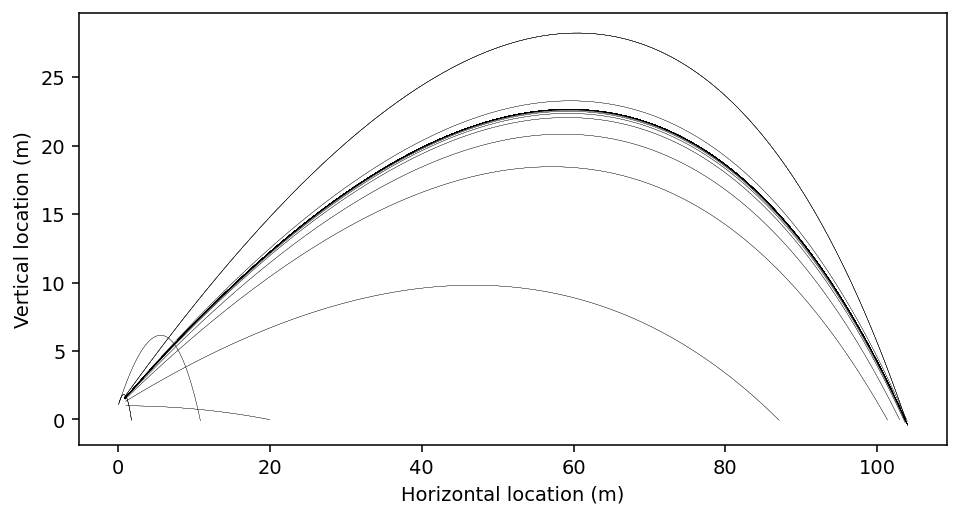

In [11]:
max_strength = 1.0

import scipy.optimize

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Horizontal location (m)")
ax.set_ylabel("Vertical location (m)")

## optimise using an optimiser that has bounds
## will never generate solutions outside of these
res = scipy.optimize.minimize(
    throw, [65.0, 0.1], method="tnc", 
    bounds=[[0, 90],
                                              [0, max_strength]]
)

print(
    "Angle {angle:.1f} degrees, distance={m:.1f}m".format(
        angle=res.x[0], m=np.abs(res.fun)
    )
)

#### Option 2: add a penalty term

$$L'(\theta) = L(\theta) + \lambda(theta)$$

In [12]:
def penalty(strength):
    # start applying constraint just before we hit
    # the hard limit
    cutoff = max_strength * 0.90
    # increase loss rapidly as we excced max strength
    return np.where(strength > cutoff,
                    (cutoff - strength) ** 2 * 500, 0)

Text(0, 0.5, 'Penalty')

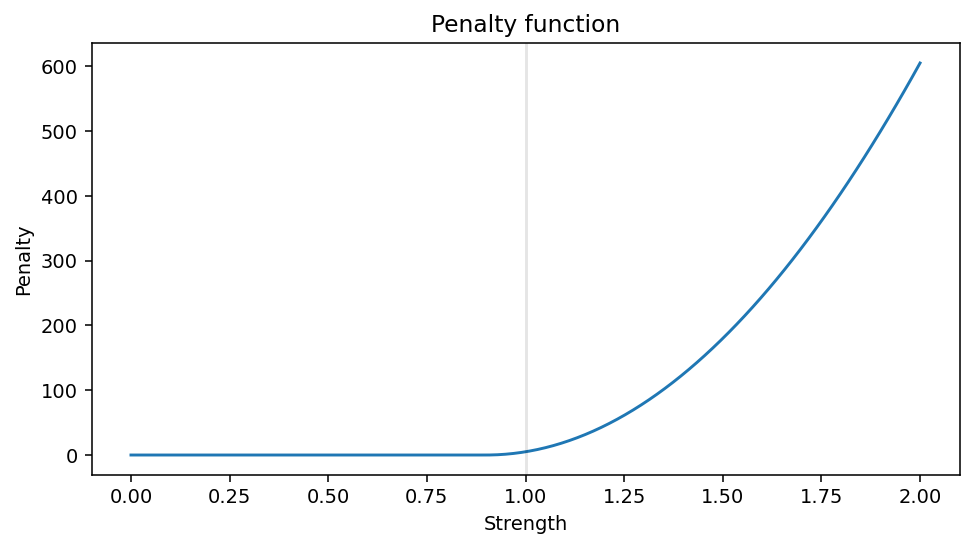

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
xs = np.linspace(0, 2.0, 100)
ax.plot(xs, penalty(xs))
ax.set_title("Penalty function")
ax.axvline(1.0, c="k", alpha=0.1)

ax.set_xlabel("Strength")
ax.set_ylabel("Penalty")

In [14]:
# super simple
# add the penalty to the objective function
def throw_penalised(theta):
    loss = throw(theta) + penalty(theta[1])
    return loss

Angle 35.2 degrees, distance=101.1m


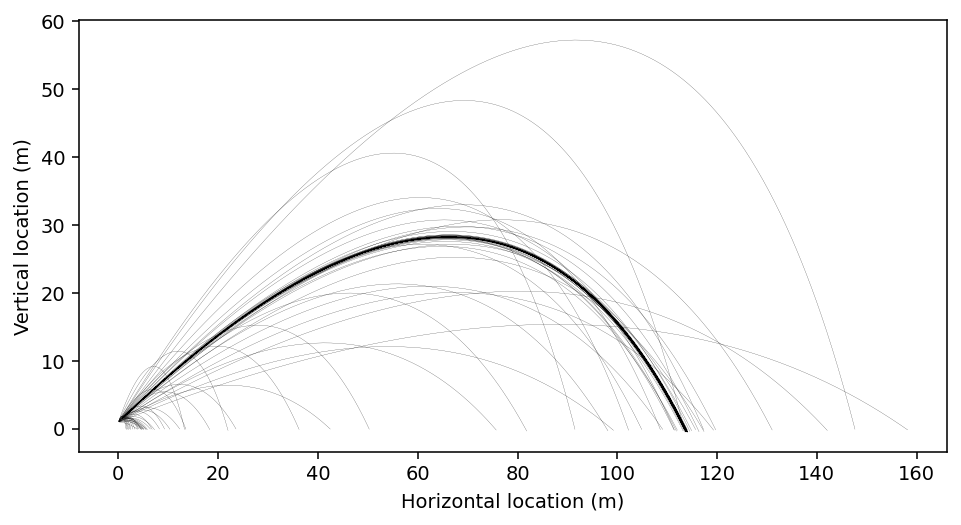

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Horizontal location (m)")
ax.set_ylabel("Vertical location (m)")

# no constraints this time
res = scipy.optimize.minimize(throw_penalised, 
                              [65.0, 0.1], method="nelder-mead")


print(
    "Angle {angle:.1f} degrees, distance={m:.1f}m".format(
        angle=res.x[0], m=np.abs(res.fun)
    )
)

---

# Properties of the objective function

## Convexity, global and local minima
An objective function may have **local minima**. A **local minimum** is any point where the objective functions increases in every direction around that point (that parameter setting). Any change in the parameters at that point increases the objective function.

An objective function is **convex** if it has a *single, global minimum*. For example, every quadratic function is a parabola (in any number of dimensions), and thus has exactly one minimum. Other functions might have regions that have local minimums but which **aren't** the smallest possible value the function could take on.

**Convexity** implies that finding any minimum is equivalent to finding the global minimum -- the guaranteed best possible solution.  This minimum is the global minimum. In a convex problem, if we find a minimum, we can stop searching. If we can show there *is no minimum*, we can also stop searching.


<img src="imgs/convex.png" width="100%">
<img src="imgs/nonconvex.png" width="100%">

<img src="imgs/convex_surfaces.png">

*Images: examples of convex and non-convex objective functions*

### Convex optimisation
If the objective function is **convex** *and* any constraints form convex portions of the search space, then the problem is **convex optimisation**. There are very efficient methods for solving convex optimisation problems, even with tens of thousands of variables. These include: 

* the constraints and objective function are linear (**linear programming**)
* quadratic objective function and linear constraints (**quadratic programming**)
* or a some specialised cases (**semi-quadratic programming**, **quadratically constrained quadratic program**). 

These are incredible powerful algorithms for solving these specific classes of optimisation problems. 

Nonconvex problems require the use of **iterative** methods (although ways of *approximating* nonconvex problems with convex problems do exist).

### Continuity
An objective function is **continuous** if for some very small adjustment to $\theta$ there is an *arbitrarily* small change in $L(\theta)$. This means that there will never be "nasty surprises" if we move slowly enough through the space of $\theta$; no sudden jumps in value.

<img src="imgs/continuous.png" width="70%">

If a function is discontinuous, local search methods are not guaranteed to converge to a solution. Optimisation for discontinuous objective functions is typically much harder than for continuous functions. This is because there could be arbitrary changes in the objective function for any adjustment to the parameters.

<img src="imgs/discontinuous.png" width="70%">

Continuity is what can make continuous optimisation easier than discrete optimisation. As we will see next week, being continuous and **differentiable** makes continuous optimisation even more powerful.


# Algorithms
## Direct convex optimisation: least squares
Sometimes we have an optimisation problem which we can specify such that the solution can be computed in one step. An example is **linear least squares**, which solves objective functions of the form:

<div class="alert alert-success alert-box">
    
$$\argmin_x L(\vec{x}) = \|A\vec{x}-\vec{y}\|_2^2, $$
</div>

that is, it finds $\vec{x}$ that is closest to the solution $A\vec{x}=\vec{y}$ in the sense of minimising the squared $L_2$ norm. The squaring of the norm just makes the algebra easier to derive. 

This equation is **convex** -- it is a quadratic function and even in multiple dimensions it must have a single, global minimum, which can be found directly. The reason we **know** it is convex is that it has no terms with powers greater than 2 (no $x^3$ etc.) and so is quadratic. Quadratic functions only ever have zero or one minimum.

The solution is given by solving the system of **normal equations**: 
$$
\left(A^\top A\right) \vec{x} = A^\top \vec{y}
$$
and therefore our solution is
$$
\vec{x}^* = \left(A^\top A\right)^{-1}A^\top \vec{y}
$$
which can also be written as
$$
\vec{x}^* = A^+ \vec{y}
$$
where $A^+$ is the **Pseudo-Inverse** of $A$.



### Line fitting
We will examine this process for the simplest possible **linear regression** example: finding gradient $m$ and offset $c$ for the line equation $$y=mx+c$$ such that the squared distance to a set of observed $(x,y)$ data points is minimised. This is a search over the $\theta=[m,c]$ space; these are the parameters. The objective function is $L(\theta) = \sum_i (y - mx_i-c)^2$, for some known data points $[x_0, y_0], [x_1, y_1],$ etc.

We can solve this directly using the **pseudo-inverse** via the SVD. This is a problem that can be solved directly in one step.

For demonstration, we will use a line with the equation $$y=2x+1, m=2, c=1$$ where we have a collection of noisy observations from this function.

In [16]:
## generate some random data, with a linear trend
# the linear regression problem; find m and c in the equation y=mx+c
line_x = np.sort(np.random.normal(0, 1, (20,)))
gradient, offset = 2, 1  # these are the "true" parameters that generated this data

# 2x + 1 and a bit of noise
line_y = (
    gradient * line_x + offset + np.random.normal(0, 0.5 * np.abs(line_x), line_x.shape)
)

# loss function
def loss(theta):
    # sum of squares of differences with estimated parameters
    e = np.sum(((line_x * theta[0] + theta[1]) - line_y) ** 2)
    return e

In [17]:
## Solution via SVD
# Using the "Vandermonde matrix" approach
## NOTE: You don't have to understand how this code works

A = np.stack([line_x ** 0, line_x ** 1]).T
A_plus = np.linalg.pinv(A)
regression = A_plus @ line_y

Text(-2, 5, 'Estimate y=1.86x+0.78')

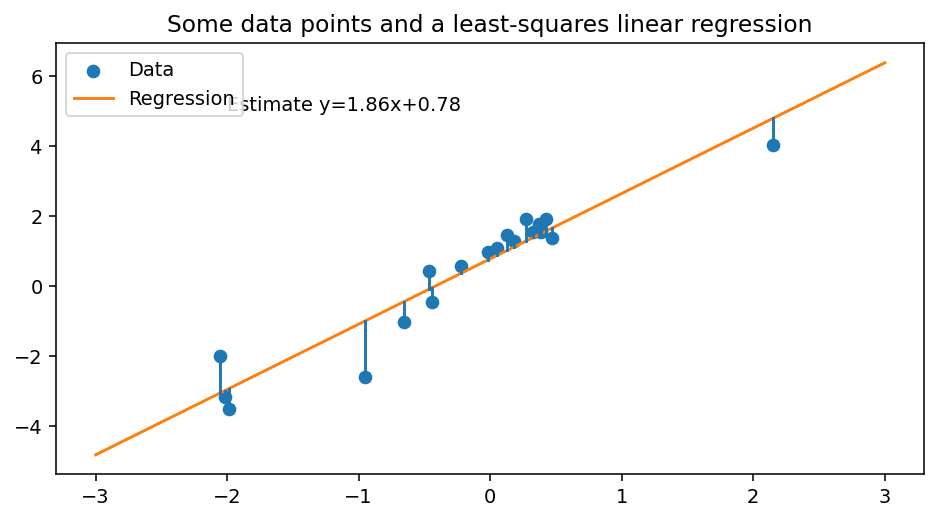

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(line_x, line_y, label="Data")
xt = np.linspace(-3, 3, 100)
ax.plot(xt, xt * regression[1] + regression[0], c="C1", label="Regression")
for i in range(len(line_x)):
    ax.plot(
        [line_x[i], line_x[i]],
        [line_x[i] * regression[1] + regression[0], line_y[i]],
        "C0",
    )

ax.legend()
ax.set_title("Some data points and a least-squares linear regression")
ax.text(-2, 5, "Estimate y=%.2fx+%.2f" % (regression[1], regression[0]))

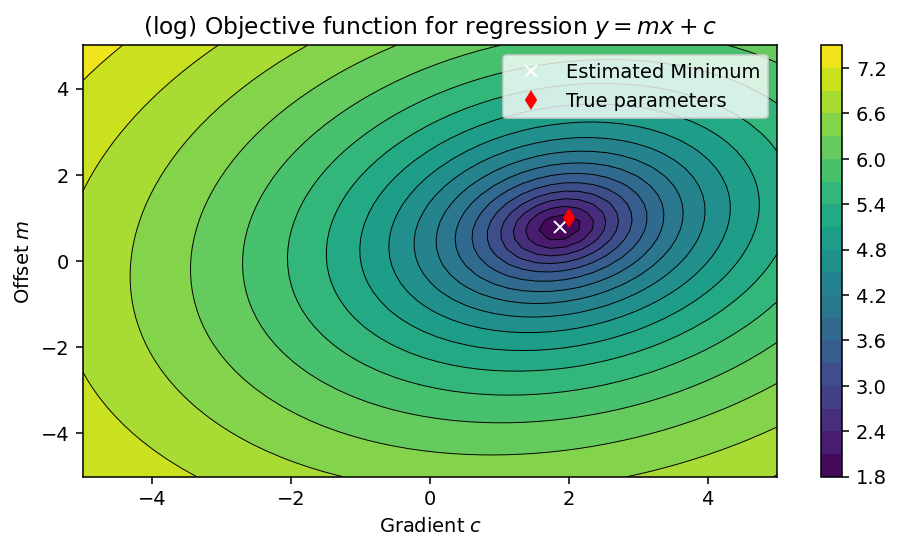

In [19]:
# now manually compute the least squares fit loss function across a reasonable area

# generate a grid
div = np.linspace(-5, 5, 50)
mx, my = np.meshgrid(div, div)

# we need to compute distance for *each* data point (for 20 of them)

mmx = np.tile(mx[:, :, None], (1, len(line_x)))
mmy = np.tile(my[:, :, None], (1, len(line_x)))

# cost function: |y - f'(x)|^2
cost_fn = np.sum(((line_x * mmy + mmx) - line_y) ** 2, axis=2)

# show the contours
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

res = ax.contourf(my, mx, np.log(cost_fn), 20)

ax.contour(my, mx, np.log(cost_fn), 19, colors="k", linewidths=0.5)
fig.colorbar(res)
ax.set_title("(log) Objective function for regression $y = mx + c$")
ax.set_xlabel("Gradient $c$")
ax.set_ylabel("Offset $m$")

ax.plot(regression[1], regression[0], "wx", label="Estimated Minimum")
ax.plot(gradient, offset, "rd", label="True parameters")
plt.legend()

## Iterative optimisation
**Iterative optimisation** involves making a series of steps in parameter space. There is a **current parameter vector** (or collection of them) which is adjusted at each iteration, hopefully decreasing the objective function, until optimisation terminates after some **termination criteria** have been met.

Iterative optimisation algorithm:

1. choose a starting point x_0
1. while objective function changing
    1. adjust parameters
    1. evaluate objective function
    1. if better solution found than any so far, record  it
1. return best parameter set found
        

## Regular search: grid search
**Grid search**, is a straightforward but inefficient optimisation algorithm for multidimensional problems. The parameter space is simply sampled by equally dividing the feasible set in each dimension, usually with a fixed number of divisions per dimension.

The objective function is evaluated at each $\theta$ on this grid, and the lowest loss $\theta$ found so far is tracked. This is simple, and can work for 1D optimisation problems. It is sometimes used to optimise *hyperparameters* of machine learning problems where the objective function may be complex but finding the absolute minimum isn't essential.

In [20]:
import itertools
# history lets us track the best solutions as we find them
# import utils.history; import imp; imp.reload(utils.history)
from utils.history import History, linear_regression_plot
        
def grid_search(L, ranges, divs):
    """L: loss function
    ranges: Parameter ranges for each dimension (e.g. [[0,1], [-1,1], [0,2]])
    divs: division per range
    """    
    o = History()
    divisions = [np.linspace(r[0], r[1], divs) for r in ranges]        
    for theta in itertools.product(*divisions):                    
        o.track(theta, L(theta))
    return o.finalise()

In [21]:


grid_results = grid_search(loss, [[-5,5], [-5,5]], 15)

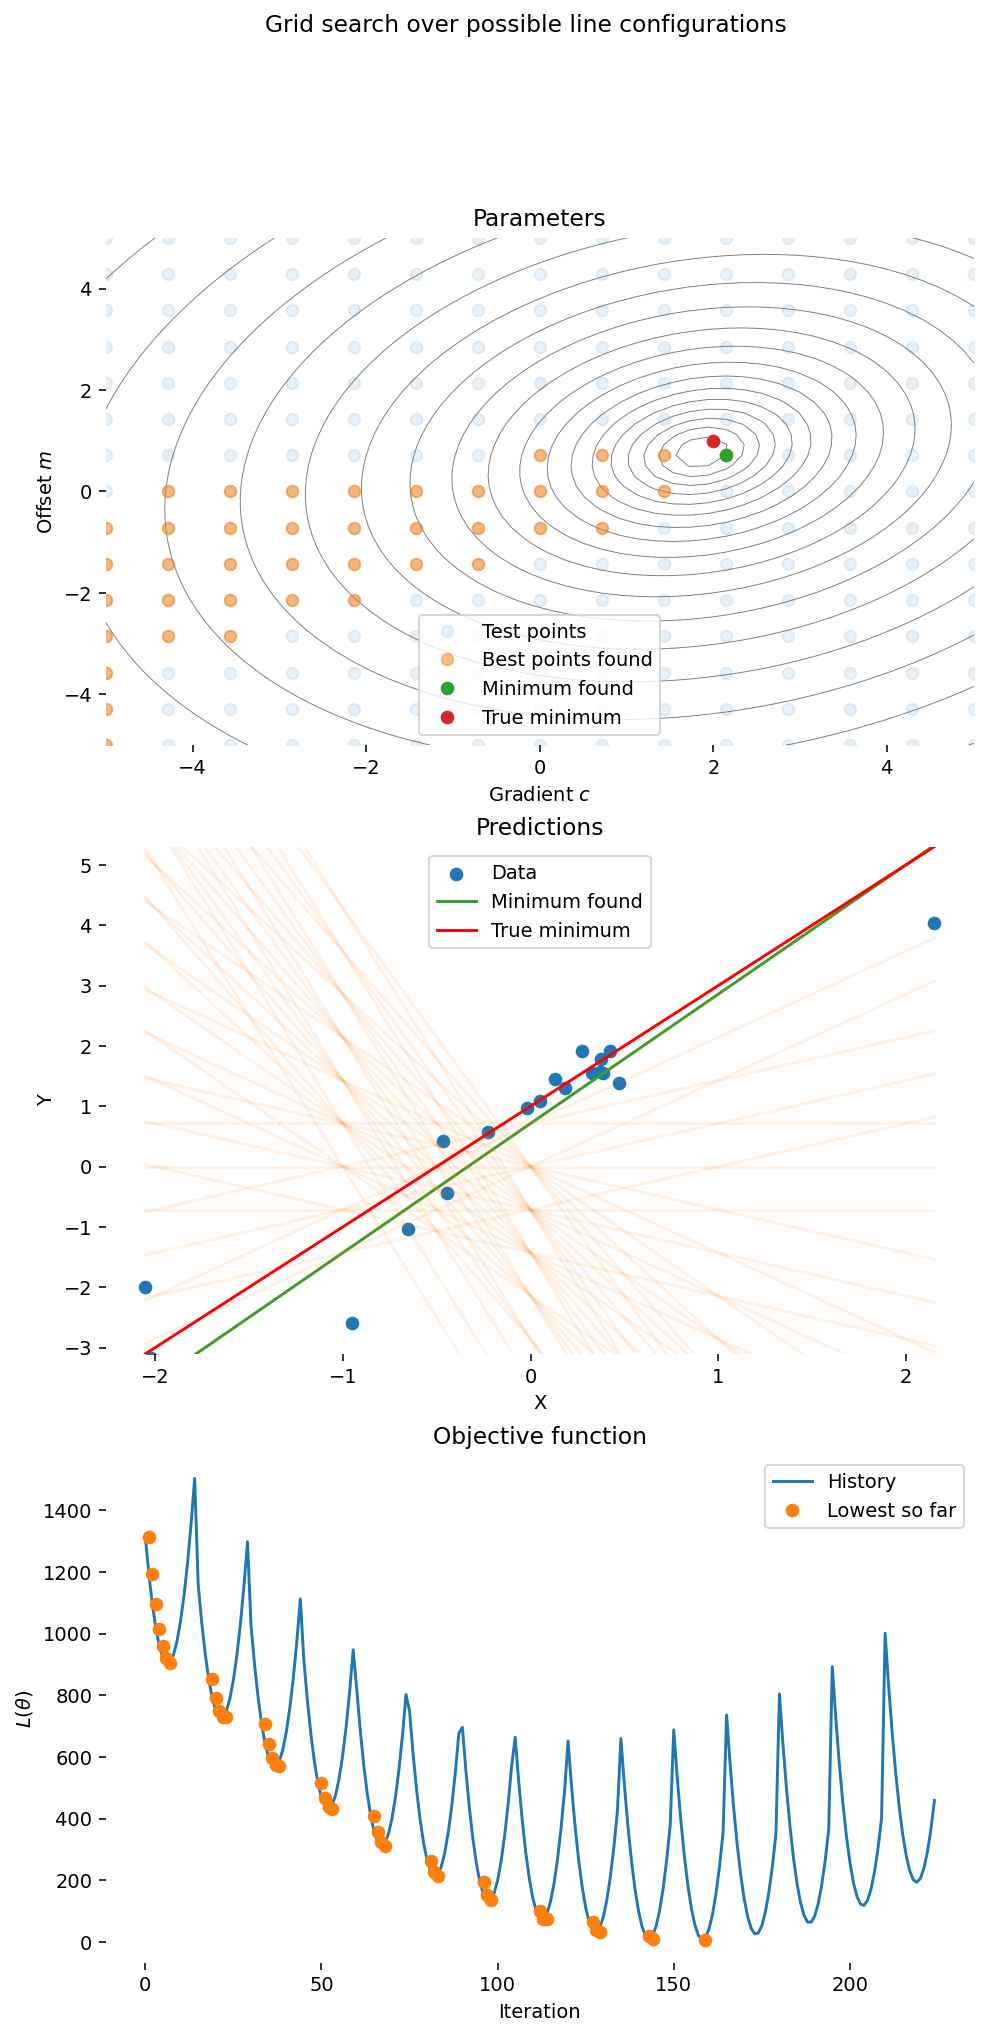

In [22]:
linear_regression_plot(grid_results, gradient, offset, line_x, line_y, opt_title="Grid search")

### Revenge of the curse of dimensionality
> Why bother optimising? Why not just search every possible parameter configuration? 

Even in relatively small parameter spaces, and where the objective function is known to be smooth this doesn't scale well.  Simply divide up each dimension into a number of points (maybe 8), and then try every combination on the grid of points that this forms, choosing the smallest result.


<img src="imgs/grid_d.png">


*[Image: grid search breaks down in high dimensions]*

While this is fine in 1D (just check 8 points) and 2D (just check 64 points), it breaks down completely if you have a 100 dimensional parameter space. This would need 

In [23]:
8**100

2037035976334486086268445688409378161051468393665936250636140449354381299763336706183397376

evaluations of the objective function! The synthesizer above has around 100 dimensions, as an example.

Even just 3 points in each dimension is totally unreasonable:

In [24]:
3**100

515377520732011331036461129765621272702107522001

### Density of grid search
If the objective function is not very smooth, then a much denser grid would be required to catch any minima.

<img src="imgs/grid_search.png">

Real optimisation problems might have hundreds, thousands or even billions of parameters (in big machine learning problems). Grid search and similar schemes are *exponential* in the number of dimensions of the parameter space.

### Pros
* Works for any continuous parameter space.
* Requires no knowledge of the objective function.
* Trivial to implement.

### Cons
* **Incredibly** inefficient
* Must specify search space bounds in advance.
* Highly biased to finding things near the "early corners" of the space.
* Depends heavily on number of divisions chosen.
<img src="imgs/bias.png" width="400px">
* Hard to tune so that minima are not missed entirely.

## Hyperparameters
Grid seach depends on the **range** searched and the spacing of the **divisions** of the grid. Most optimisation algorithms have similar properties that can be tweaked.

These properties, which affect the way in which the optimiser finds a solution, are called **hyperparameters**. They are not parameters of the objective function, but they do affect the results obtained. 

A perfect optimiser would have no hyperparameters -- a solution should not depend on how it was found. But in practice, all useful optimisers have some number of hyperparameters which will affect their performance. Fewer hyperparameters is usually better, as it is less cumbersome to tune the optimiser to work.


## Simple stochastic: random search
The simplest such algorithm, which makes *no* assumptions other than we can draw random samples from the parameter space, is **random search**.  

The process is simple:
* Guess a random parameter $\theta$
* Check the objective function $L(\theta)$
* If $L(\theta)<L(\theta^*)$ (the previous best parameter $\theta^*$), set $\theta^*=\theta$

There are many possibilities for a termination condition, such as stopping after a certain number of iterations after the last change in the best loss. The simple code below uses a simple fixed iteration count and therefore makes no guarantee that it finds a good solution at all.


### Pros
* Random search cannot get trapped in local minima, because it uses no local structure to guide the search. 
* Requires no knowledge of the structure of the objective function - not even a topology.
* Very simple to implement.
* Better than grid search, almost always.

### Cons
* *Extremely inefficient* and is usually only appropriate if there is no other mathematical structure to exploit.
* Must be possible to randomly sample from the parameter space (usually not a problem, though).
* Results do not necessarily get better over time. Best result might be found in the first step or a million steps later. There is no way to predict how the optimisation will proceed.

In [25]:
def random_search(L, sample_fn, iters):
    """L: loss function
    sample_fn: calling this should draw one random sample from the parameter space
    iters: number of iterations to run the optimisation for
    """
    o = History()
    for i in range(iters):
        theta = sample_fn()        
        o.track(theta, L(theta))    
    return o.finalise()


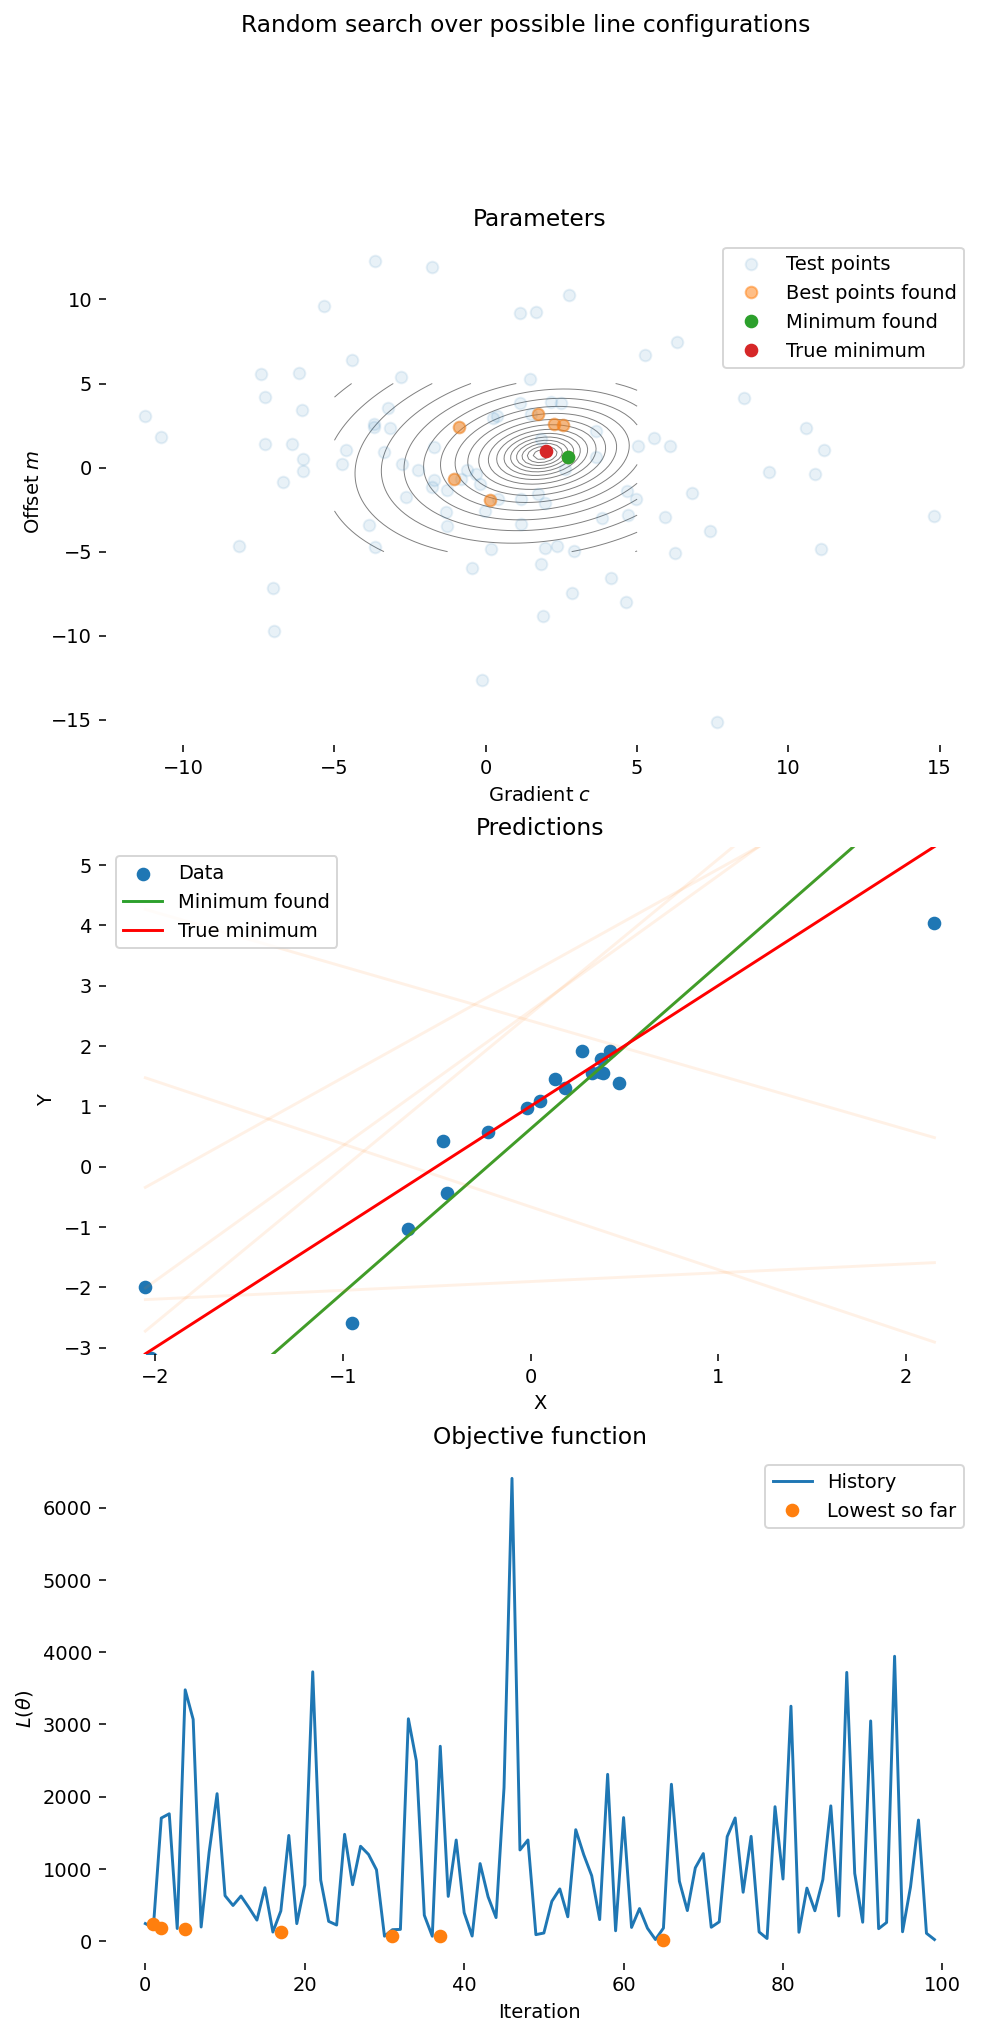

In [26]:
def sample():
    return np.random.normal(0,5,size=(2,))

random_results = random_search(loss, sample, 100)
linear_regression_plot(random_results, gradient, offset, line_x, line_y, "Random search")

### bogosort
The (joke) sorting algorithm **bogosort** uses random search to sort sequences. The algorithm is simple:

* randomise the order of the sequence
* check if it is sorted
    * if it is, stop; otherwise, repeat

This is amazingly inefficient, taking $O(n!)$ time to find a solution, which is even worse than exponential time. In this application, the parameter space (all possible orderings) is so huge that random search is truly hopeless. It is particularly poor because of the binary nature of the loss function -- either it is perfect, or it is disregarded, so we will never even get approximately correct results.

However, it is a correct implementation of a sorting algorithm.


In [27]:
def bogosort(x):    
    # check if we have any decreasing elements left
    while np.any(np.diff(x)<0):    
        np.random.shuffle(x)
    return x

In [28]:
bogosort([5,6,1,3,2,9])

[1, 2, 3, 5, 6, 9]

In [29]:
%%timeit
# bogosort will sort a 5 element array in ~500 microseconds
bogosort([3,2,1,4,2])

# it would take 3 years to sort a 13 element array
# and longer than the age of the universe to sort a 21 element array

1.81 ms ± 53 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Metaheuristics

There are a number of standard **meta-heuristics** than can be used to improve random search.

These are:
* **Locality** which takes advantage of the fact the objective function is likely to have similar values for similar parameter configurations. This assumes *continuity* of the objective function.
* **Temperature** which can change the rate of movement in the parameter space over the course of an optimisation. This assumes the existence of local optima.
* **Population** which can track multiple simultaneous parameter configurations and select/mix among them.
* **Memory** which can record good or bad steps in the past and avoid/revisit them.


## Locality
**Local search** refers to the class of algorithms that make *incremental* changes to a solution. These can be much more efficient than random search or grid search when there is some continuity to the objective function. However, they are subject to becoming trapped in **local minima**, and not reaching the **global minimum**. Since they are usually exclusively used for nonconvex problems, this can be a problem.

This implies that the output of the optimisation depends on the **initial conditions**. The result might find one local minimum starting from one location, and a different local minimum from another starting parameter set.

<img src="imgs/local_minima.png">

Local search can be thought of forming **trajectory** (a path) through the parameter space, which should hopefully move from high loss towards lower loss.



### Hill climbing: local search
**Hill climbing** is a modification of random search which assumes some topology of the parameter space, so that there is a meaningful concept of a **neighbourhood** of a parameter vector; that we can make incremental changes to it. Hill climbing is a form of **local search**, and instead of drawing samples randomly from the parameter space, randomly samples configurations *near* the current best parameter vector. It makes incremental adjustments, keeping transitions to neighbouring states only if they improve the loss.

**Simple hill climbing** adjusts just one of the parameter vector elements at a time, examining each "direction" in turn, and taking a step if it improves things. **Stochastic hill climbing** makes a random adjustment to the parameter vector, then either accepts or rejects the step depending on whether the result is an improvement.

The name *hill climbing* comes from the fact that the algorithm randomly wanders around, only ever taking uphill (or downhill, for minimisation) steps. Because hill climbing is a **local search** algorithm, it is vulnerable to getting stuck in local minima. Basic hill climbing has no defence against minima and will easily get trapped in poor solutions if they exist. Simple hill climbing can also get stuck behind **ridges** and all forms of hill climbing struggle with **plateaus** where the loss function changes slowly. 

#### Pros
* Not much more complicated than random search
* Can be *much* faster than random search

#### Cons
* Hard to choose how much of an adjustment to make
* Can get stuck in minima
* Struggles with objective function regions that are relatively flat
* Requires that the objective function be (approximately) continuous

In [30]:
def stochastic_hill_climbing(L, guess_fn, neighbour_fn, iters):
    """
    L: loss function
    theta_0: initial guess
    neighbour_fn(theta): given a parameter vector, returns a random vector nearby
    iters: number of iterations to run the optimisation for
    """
    o = History()
    theta_0 = guess_fn()
    o.track(theta_0, L(theta_0))
    for i in range(iters):
        proposal = neighbour_fn(o.best_theta)
        o.track(proposal, L(proposal))        
    return o.finalise()

In [31]:
def sample():
    # guess
    return np.random.normal(0,5,size=(2,))

def neighbour(x):
    # adjust the guess a bit
    return np.random.normal(0,0.25,x.shape) + x


hill_results = stochastic_hill_climbing(loss, sample, neighbour, 800)

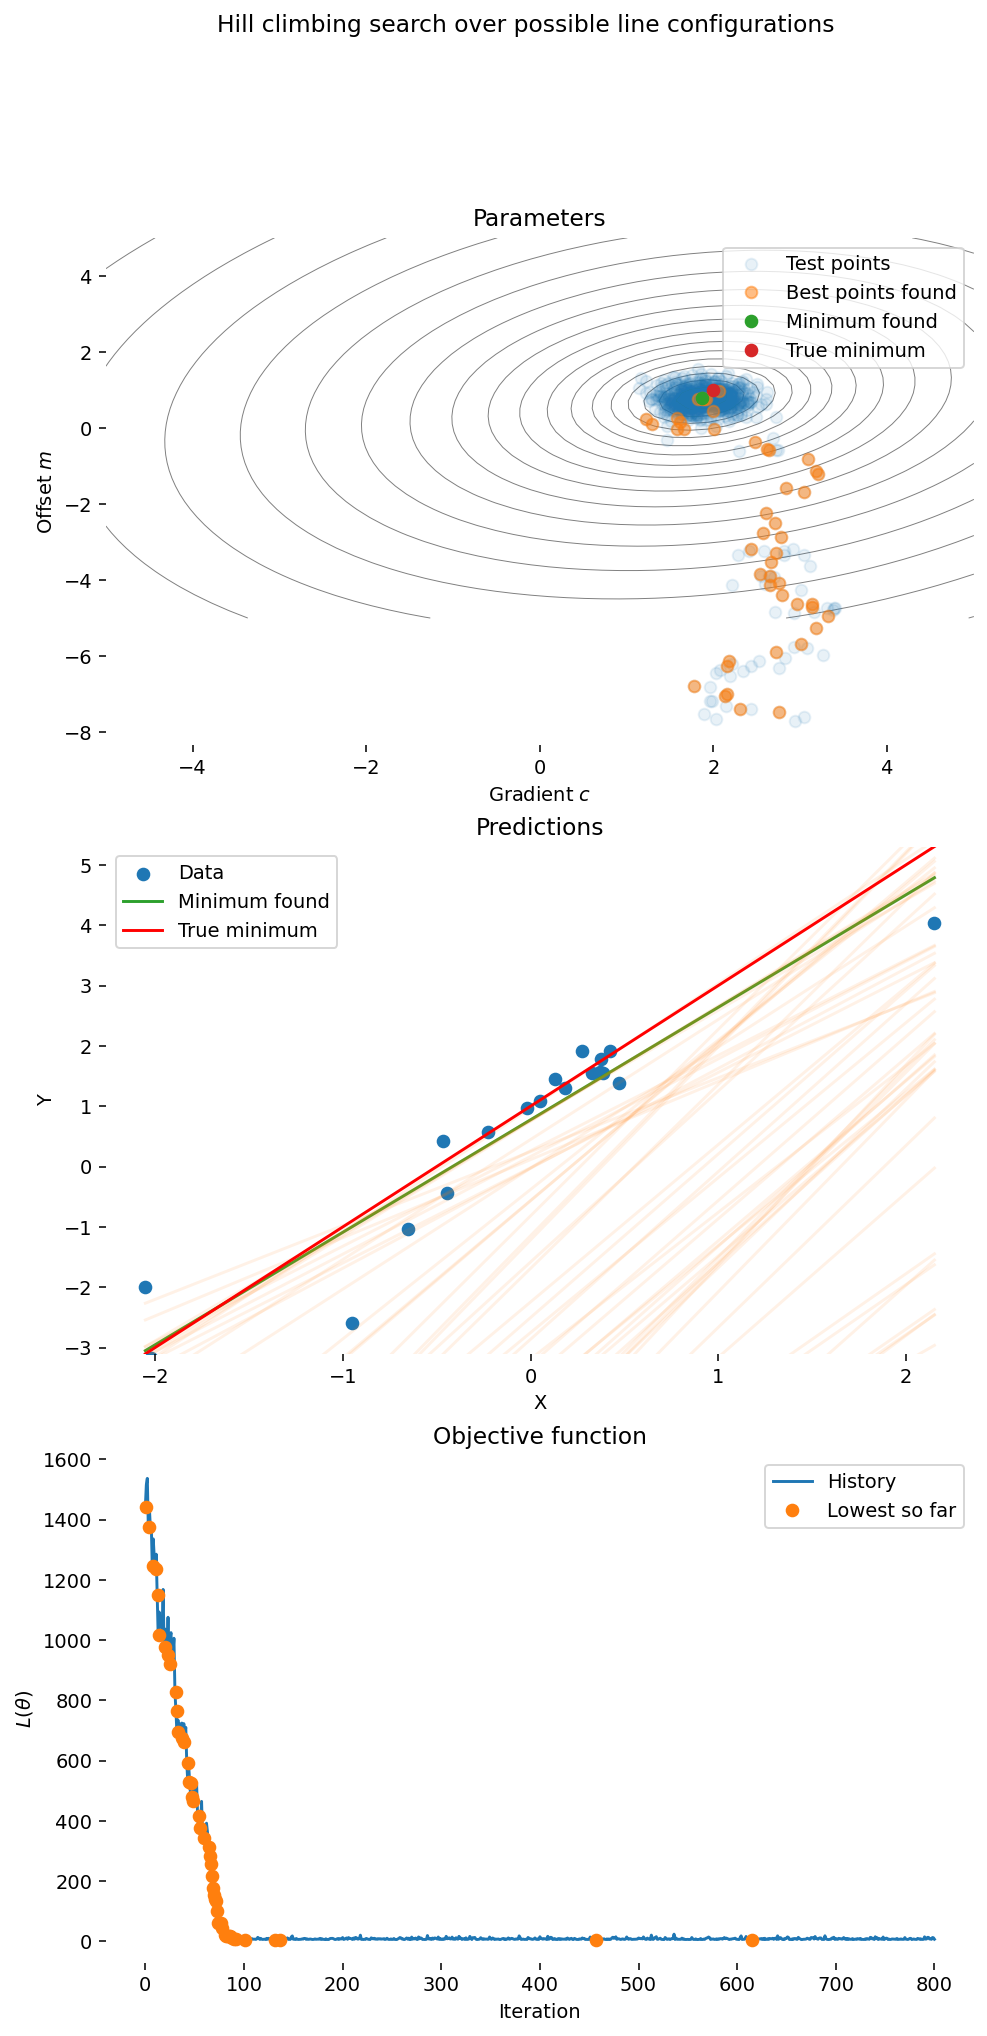

In [32]:
linear_regression_plot(hill_results, gradient, offset, line_x,line_y, "Hill climbing search")

Again, there are many ways this basic algorithm can be tweaked: 
* **adaptive local search** where the size of the neighbourhood can be adapted (e.g. if no improvement in $n$ iterations, increase size of random steps)
* **multiple restarts** can be used to try and avoid getting stuck in local minima by running the process several times for random initial guesses. This is another meta-heuristic -- a heuristic applied to the search algorithm itself.

## Temperature

### Simulated annealing: temperature schedules and minima escaping
**Simulated annealing** extends hill-climbing with the ability to sometimes randomly go uphill, instead of always going downhill. It uses a **temperature schedule** that allows more uphill steps at the start of the optimisation and fewer ones later in the process. This is used to overcome ridges and avoid getting stuck in local minima.

The idea is that allowing random "bad jumps" early in a process can help find a better overall configuration.

<img src="imgs/ridge.png" width="50%">

*Image: hill climbing would get stuck in the local minimum at the left. Simulated annealing would sometimes accept "bad" local changes to ride over hills and get to a better minimum.*

The "temperature schedule" comes from the idea of **annealing** metals. Molten metals have molecules bouncing around all over the place. As they cool, the random bouncing gets smaller and smaller as the molecules lock together into a tight lattice. Fast cooling results in less well structured metals than slow cooling.

<video src="imgs/anneal.mp4" autoplay="true" loop="true" controls="true">

### Accepting you have to go uphill sometimes
Simulated annealing uses the idea of **acceptance probability**. Instead of just accepting any random change that decreases the loss, we randomly accept some proportion of jumps that might temporarily increase the loss, and slowly decrease the proportion of these over time.

Given the current loss $l = L(\theta)$ and a proposed new loss $l^\prime = L(\theta+\Delta\theta),$ where $\Delta\theta$ represents a random perturbation of $\theta$, we can define a probability $P(l, l^\prime, T(i))$ which is the probability of jumping from $\theta$ to $\Delta\theta$ at iteration $i$.

A common rule is:
* $P(l, l^\prime, T(i))=1$ if $l^\prime < l$, i.e. always go downhill.
* $P(l,l^\prime,T(i)) = e^{-(l-l^\prime)}T(i)$ i.e. take uphill jumps if the relative decrease is small.

$T(i)$ is typically an exponentially decaying function of the iteration number, so that large jumps are accepted at the start, even if they go *way* uphill, but there is a decreasing tendency to make uphill jumps as time goes on.

For example, $$T(i) = e^{\frac{-i}{r}},$$ where $i$ is the iteration number, $r$ is the cooling rate and $T$ is the temperature.

<img src="imgs/Hill_Climbing_with_Simulated_Annealing.gif">

*[Image: By Kingpin13 - Own work, CC0, [from Wikipedia(https://commons.wikimedia.org/w/index.php?curid=25010763)]*

It was originally invented to help design VLSI chip layouts and routing at IBM. IBM engineers had a few "gurus" who knew how to map out "good paths" on the silicon, and they couldn't keep up with the layout demand. The annealing procedure was introduced to find good routings automatically. It was better than the gurus were. And cheaper too. 

#### Pros
* Much less sensitive to getting trapped in minima than hill climbing
* Easy to implement
* Empirically very effective
* Fairly effective even in mixed continuous/discrete settings.

#### Cons
* Depends on good choice for the temperature schedule and neighbourhood function, which are extra free parameters to worry about.
* No guarantees of convergence
* Slow if the uphill steps are not actually needed

Text(0.5, 1.0, 'A possible simulated annealing temperature schedule')

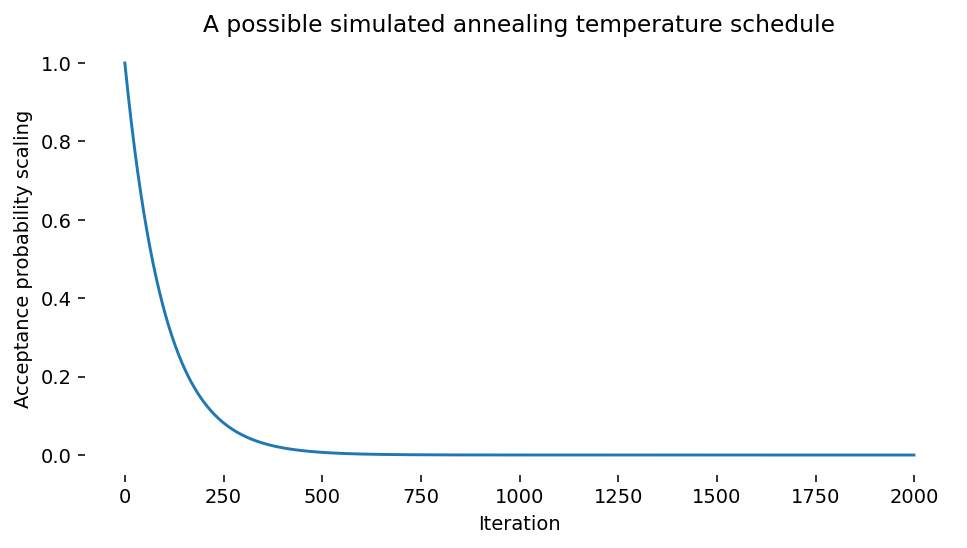

In [33]:
def temperature(iteration):
    return np.exp(-iteration/100.0)

iterations = np.arange(2000)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(iterations, temperature(iterations))
ax.set_xlabel("Iteration")
ax.set_ylabel("Acceptance probability scaling")
ax.set_frame_on(False)
ax.set_title("A possible simulated annealing temperature schedule")

In [34]:

def simulated_anneal(L, guess_fn, neighbour_fn, 
                     temperature_fn, iters):
    """
    L: loss function
    guess_fn: function that should return an initial guess
    neighbour_fn(theta): given a parameter vector, 
                         returns a random vector nearby
    temperature_fn(iter): given an iteration,     
                        return the temperature schedule
    iters: number of iterations to run the optimisation for
    """
    o = History()
    theta_0 = guess_fn()
    o.track(theta_0, L(theta_0))
    state = theta_0.copy()
    loss = L(theta_0)
    for i in range(iters):
        proposal = neighbour_fn(state)        
        proposal_loss = L(proposal)                
        # climb if we can
        if proposal_loss<loss:
            o.track(proposal, proposal_loss, force=True)   
            loss, state = proposal_loss, proposal
            
        else:                                   
            # check how bad this jump might be
            p = np.exp(-(proposal_loss-loss)) * temperature_fn(i)                                    
            # randomly accept the jump with the given probability
            if np.random.uniform(0,1)<p:                
                o.track(proposal, proposal_loss, force=True)                                    
                loss, state = proposal_loss, proposal
            else:
                o.track(proposal, proposal_loss)                                    
    return o.finalise()

<IPython.core.display.Javascript object>


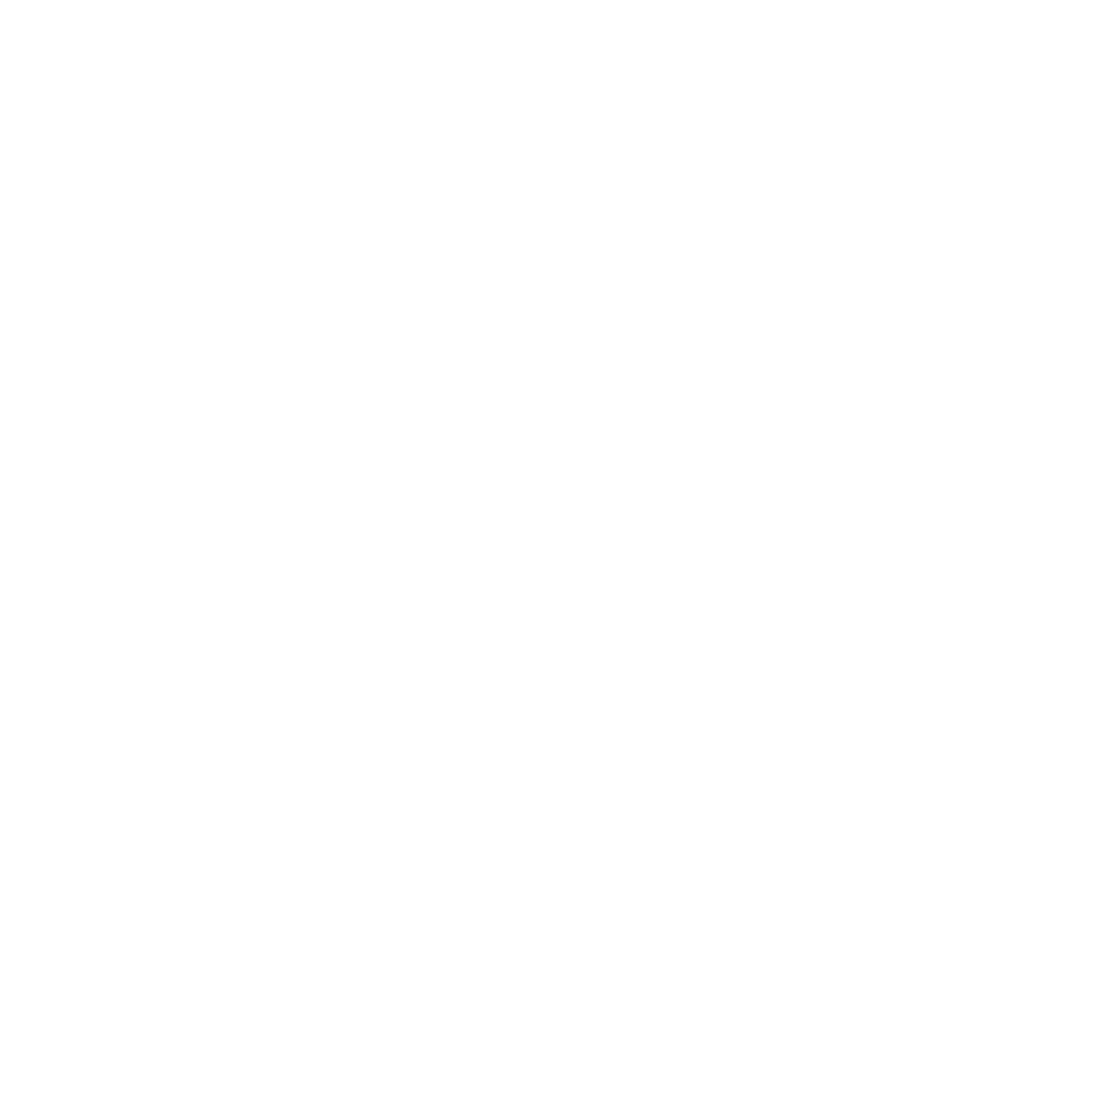

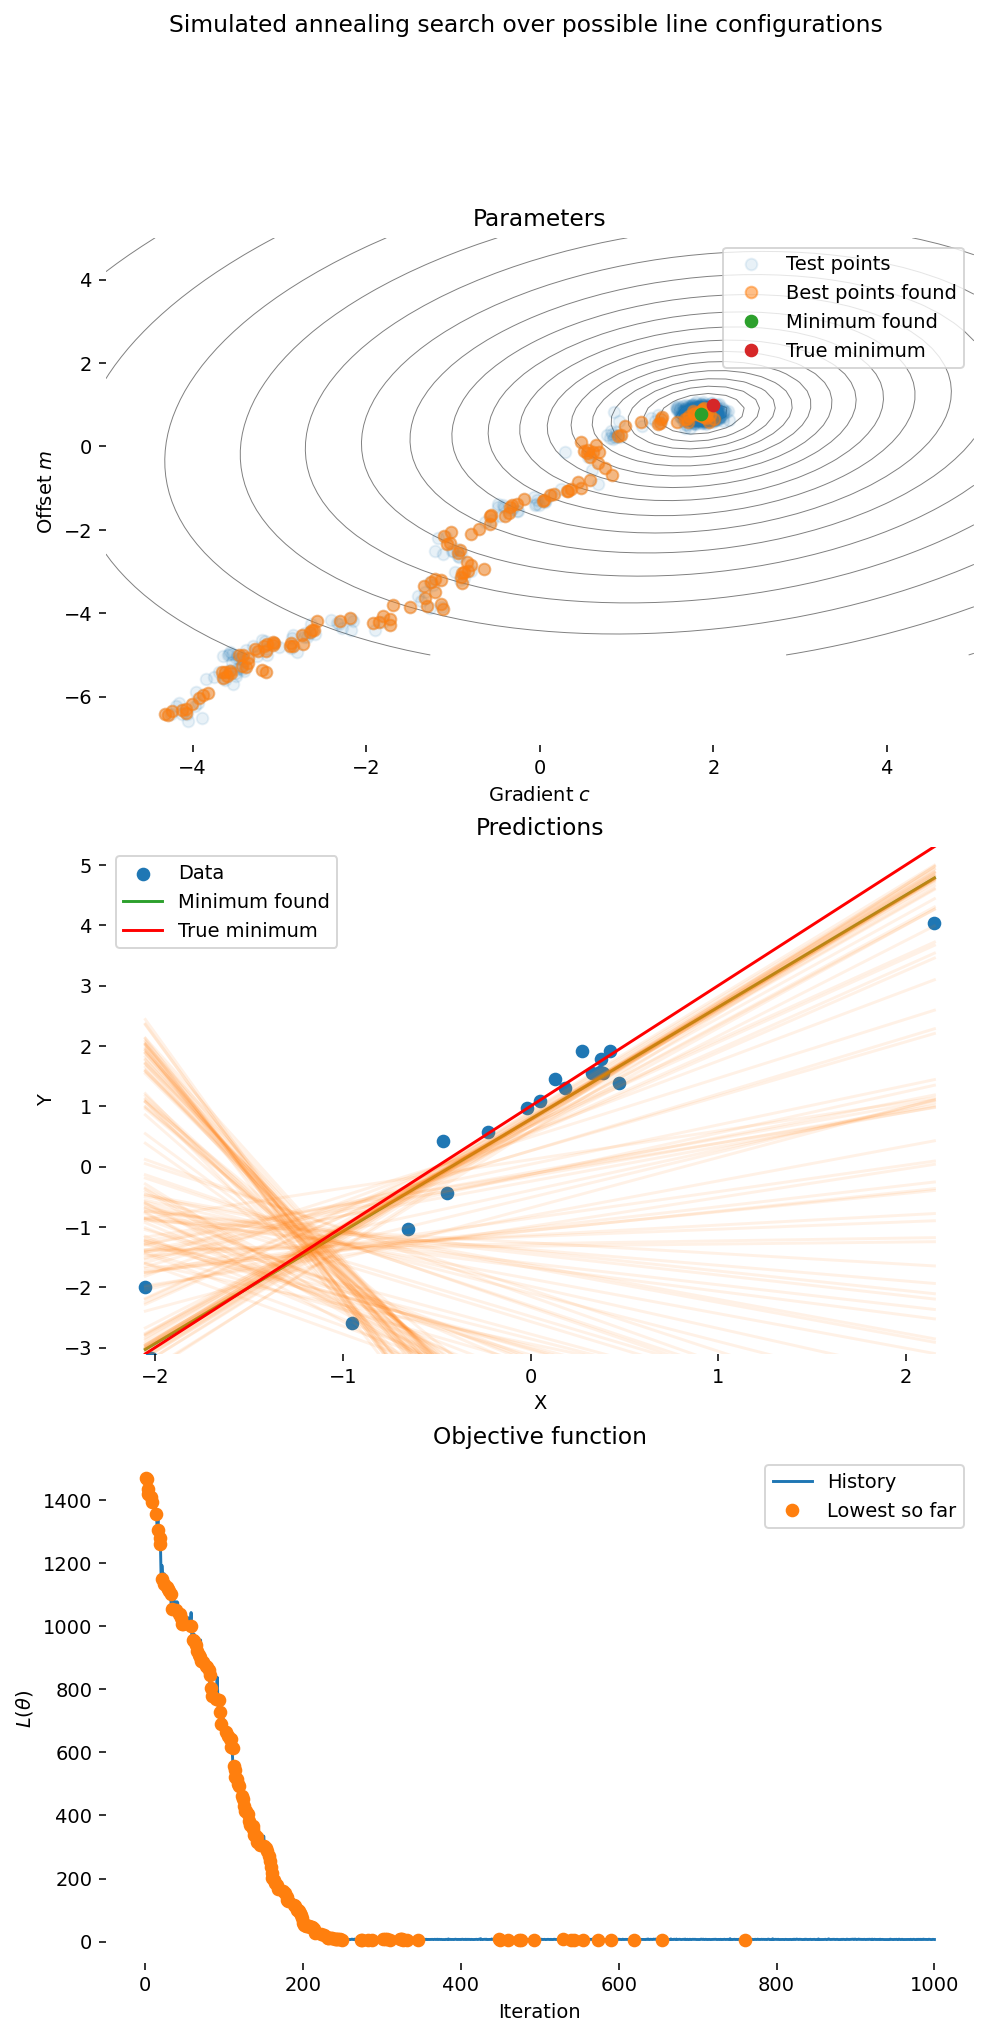

In [56]:
%matplotlib inline

def sample():
    # guess
    return np.random.normal(0,5,size=(2,))

def neighbour(x):
    # adjust the guess a bit
    return np.random.normal(0,0.1,x.shape) + x

def temperature(iteration):    
    return np.exp(-iteration/100.0)

anneal_results = simulated_anneal(loss, sample, neighbour, temperature, 1000)
linear_regression_plot(anneal_results, gradient, offset, line_x, line_y, "Simulated annealing search")

### More complicated example: finding evenly spaced points
This isn't very impressive for the line fitting, which is a very simple convex function; there are no local minima to get trapped in. We can look at the problem of finding a collection of points that are evenly spaced. This is non-convex (and has an infinite number of equal minima), and much harder to solve than fitting a line to some points.

This is a task particularly suited to simulated annealing-style approaches.

In [36]:
from evenspace import pt_fit_loss, pt_fit_plot

def pt_neighbour(x):
    return x + np.random.normal(0, 0.005, x.shape)

def pt_guess():
    return np.random.uniform(0,1, (64,2)).ravel()

def pt_temperature(iteration):
    return np.exp(-iteration/1000.0)

res = simulated_anneal(lambda x:pt_fit_loss(x, shape=(64,2)), pt_guess, pt_neighbour, pt_temperature, 10000)


In [43]:
print(res.iters)

10001


<IPython.core.display.Javascript object>


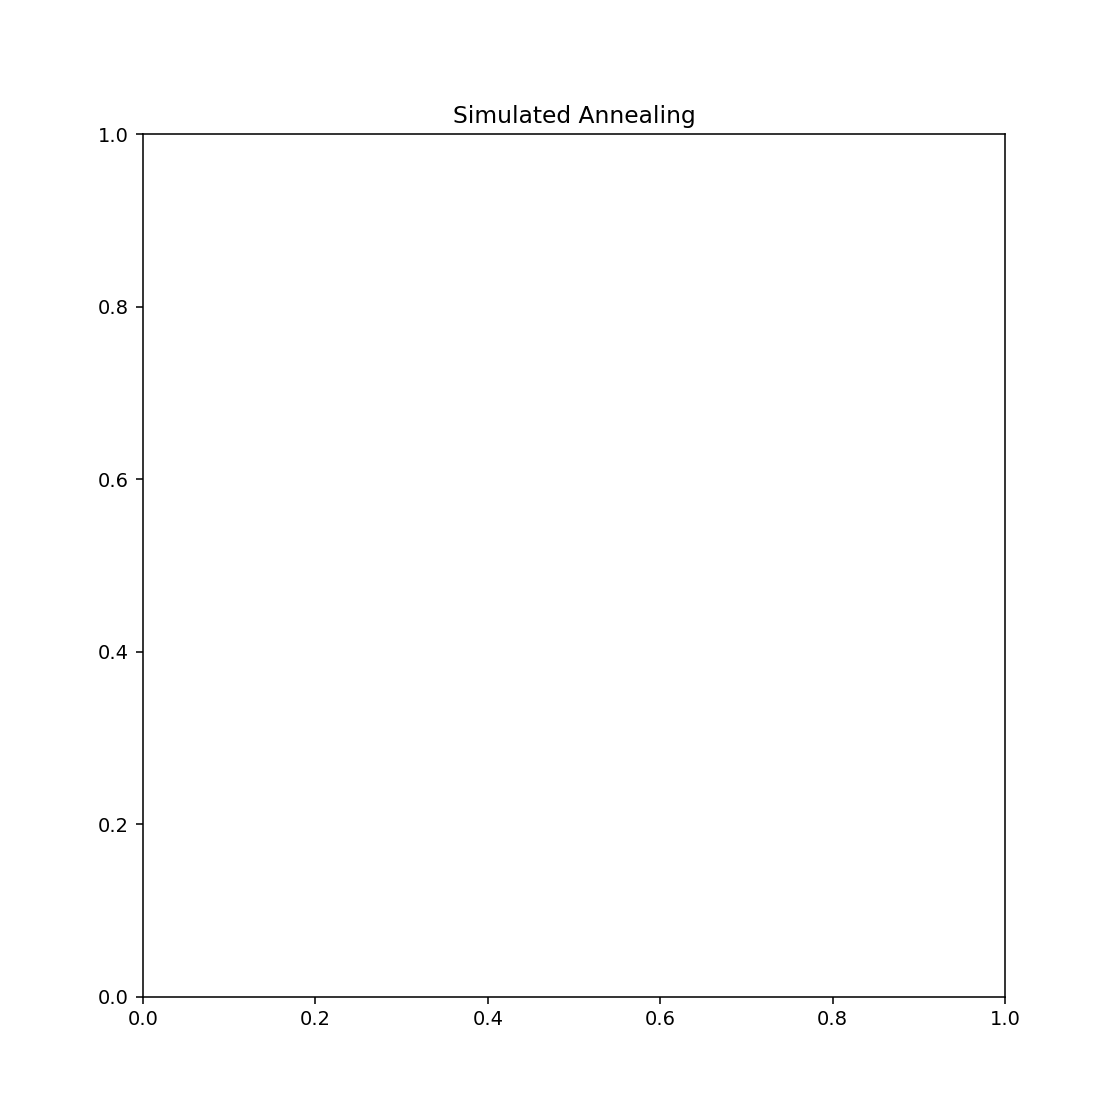

In [58]:

# animate the result
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt

from evenspace import pt_fit_loss, pt_fit_plot
import evenspace

import importlib
importlib.reload(evenspace)



#plt.figure(figsize=(16,16))


evenspace.pt_fit_plot(res, (64,2), temperature_fn=pt_temperature, title="Simulated Annealing", figsize=8)    

In [59]:
# restore normal plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)

## Population
Another nature-inspired variant of random search is to use a **population** of multiple competing potential solutions, and to apply some analogue of **evolution** to solving optimisation. This involves some of:

* **mutation** (introducing random variation)
* **natural selection** (solution selection)
* **breeding** (interchange between solutions)

This class of algorithms are often called **genetic algorithms** for obvious reasons. All genetic algorithms maintain some population of potential solutions (a set of vectors $\vec{\theta_1}, \vec{\theta_2}, \vec{\theta_3}, \dots$), and some rule which is used to preserve some members of the population and cull others. The parameter set is referred to as the **genotype** of a solution.

Simple population approaches simply use small random perturbations and a simple selection rule like "keep the top 25% of solutions, ordered by loss". Each iteration will perturb the solutions slightly by random mutation, cull the weakest solutions, then copy the remaining "fittest" solutions a number of times to produce the offspring for the next step. The population size is held constant from iteration to iteration. This is just random local search with population. The idea is that this can explore a larger area of the space than simple local search and maintain multiple possible hypotheses about what might be good during that time.

#### Crossover rules
More advanced algorithms introduce some form of **breeding** or **crossover**. David Mackay's chapter ["Why have Sex? Information Acquisition
and Evolution
"](http://www.inference.org.uk/mackay/itprnn/ps/265.280.pdf) explains some of the motivation for introducing sexual reproduction. Crossover introduces some combination of the fittest solutions as the next iteration (sexual reproduction), instead of simply copying the "parents" (asexual reproduction). 

In other words, crossover "merges" two possible parameter vectors $\theta_{mum}$ and $\theta_{dad}$ to form a new child parameter $\theta_{baby}$ (although of course we are not limited to just two sexes). Crossover works well when the parameter vector can be partitioned into distinct components, where offspring can plausibly inherit good qualities from both parents. It works less well when the crossover simply becomes a mishmash of parent qualities which average out.

Genetic algorithms have been used for many practical problems which are hard to solve with existing techinques, like antenna design for spacecraft.

<img src="imgs/xband-antenna.jpg">

*Image: The 2006 NASA ST5 spacecraft antenna. This complicated shape was found by an evolutionary computer design program to create the best radiation pattern. Source: [Wikipedia](https://en.wikipedia.org/wiki/Evolved_antenna#/media/File:St_5-xband-antenna.jpg), public domain*

There is a very interesting [article on Damn Interesting](https://www.damninteresting.com/on-the-origin-of-circuits/) about a genetic algorithm which "learned" to use a subtle hardware feature the designers didn't even know about to optimise a circuit; an example of how the general approach of optimisation can help solve problems without expert insight.

<img src="imgs/velociraptors.gif" width="100%">

*Animation from [Flexible Muscle-Based Locomotion for Bipedal Creatures
Geijtenbeek, T., van de Panne, M. & Stappen, A.F. van der (2013)](http://www.goatstream.com/research/)*

There are *many, many* variations of genetic algorithms, including isolating populations to get "island-like" specialised selection, variable mutation rates, hybrid simulated annealing approaches, and so on.

In [60]:

def genetic_search(L, pop, guess_fn, mutation_fn, iters, keep=0.25):
    o = History()
    # create the initial population randomly
    population = np.array([guess_fn() for i in range(pop)])
    d = len(guess_fn()) # store dimensionality of problem
    loss = np.zeros(pop)
    
    for i in range(iters):                
        for j in range(pop):                        
            # could also mutate *everyone* here
            # this works better in asexual reproduction            
            loss[j] = L(population[j])
            
        # order by loss
        order = np.argsort(loss)
        loss = loss[order]
        population = population[order]
        
        # replicate top "keep" fraction of individuals
        top = int(pop * keep)
        for j in range(top, pop):
            # sexual reproduction
            mum = np.random.randint(0, top)
            dad = np.random.randint(0, top)
            chromosones = np.random.randint(0,2,d)  
            
            # select elements from each dimension randomly from mum and dad
            population[j]  = mutation_fn(np.where(chromosones==0, population[mum], population[dad]))             
            
        # track the best individual so far
        o.track(population[0], loss[0])            
    return o.finalise()

In [ ]:
%matplotlib inline
ga_results = genetic_search(loss, 20, sample, neighbour, 1000)
print(ga_results)
linear_regression_plot(ga_results, gradient, offset, line_x, line_y, "GA search")

In [ ]:

# animate the result
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt

# do GA search this time
res = genetic_search(lambda x:pt_fit_loss(x, (64,2)), 50, pt_guess, pt_neighbour, 500)

# plot the results
pt_fit_plot(res, (64,2),  title="Genetic Algorithm")    

### Genetic algorithms: population search
#### Pros
* Easy to understand and applicable to many problems.
* Requires only weak knowledge of the objective function
* Can be applied to problems with both discrete and continuous components.
* Some robustness against local minima, although hard to control.
* Great flexibility in parameterisation: mutation schemes, crossover schemes, fitness functions, selection functions, etc.

#### Cons
* Many, many "hyperparameters" to tune which radically affect the performance of the optimisation. How should you choose them?
* No guarantee of convergence; *ad hoc*.
* (Very) slow compared to using stronger knowledge of the objective function.
* Many evaluations of objective function are required: one per population member per iteration.

## Memory
The optimisation algorithms we have seen so far are **memoryless**. They investigate some part of the solution space, check the loss, then move on. They may end up checking the same, or very similar, solutions over and over again. This inefficiency can be mitigated using some form of **memory**, where the optimiser remembers where "good" and "bad" bits of the parameters space are, and  makes decisions using this memory. In particular, we want to remember good **paths in solution space**. 


## Memory + population 

### Ant colony optimisation

<img src="imgs/ant_guys.jpg"> <br><br>*.[Original Image (without the meme text!)](https://flickr.com/photos/usgsbiml/23510610086 "Velvet Ant, face, Badlands, Pennington Co, SD_2013-12-31-14.25") by [Sam Droege](https://flickr.com/people/usgsbiml) shared [public domain](https://creativecommons.org/publicdomain/mark/1.0/)*

Ants are really good at finding food (exploration), and then leading the whole colony to the food source to explore and extract all of the food (exploitation). They do this, without requiring any complex coordination. Instead, ants wander about until they find something to eat. Then, they leave a trail of *pheromones* (smells) behind them and wander back to the anthill. Other ants can follow this trail to find the food and check the whole area for any really tasty bits. 

**Ant colony optimisation** combines memory and population heuristics. It uses the idea of **stigmergy** to optimise problems:

<img src="imgs/ants.png" width="70%">

> **stigmergy**: A mechanism of spontaneous, indirect coordination between agents or actions, where the trace left in the environment by an action stimulates the performance of a subsequent action. [wiktionary.org]

<img src="imgs/termites.jpg"> <br><br>*.**Stigmergy** explains how termites are able to construct vast, sophisticated "buildings" to live in despite their tiny brains. [Image](https://flickr.com/photos/david55king/787908916 "0729 Litchfield Magnetic Termite Mounds") by [david55king](https://flickr.com/people/david55king) shared [CC BY](https://creativecommons.org/licenses/by/2.0/)*

In terms of optimisation  this means:
* having a population of parameter sets ("ants")
* having a memory of good paths through the space ("pheromones")



Ants who find good parts of the space (i.e. low objective function) leave a trail of positive "pheromones", by storing marker vectors. Other ants will move towards those pheromones, and eventually follow paths that lead to good solutions. Over time (i.e. as iterations increase), the pheromones evaporate so that the ants don't get constrained into one tiny part of the space. Instead of using the physical environment, we use auxiliary data structures to memorise good paths through the parameter space, to avoid repetitious searching.

ACO is particularly well suited to path-finding and route-finding algorithms, where the memory structure of the pheromone trail corresponds to the solution structure.

#### Pros
* Can be very effective in spaces where good solutions are separated by large, narrow valleys.
* Can use fewer evaluations of the objective function than genetic algorithm if pheromones are effective.
* When it works, it really works.

#### Cons
* Moderately complex algorithm to implement.
* No guarantee of convergence; *ad hoc*.
* Even *more* hyperparameters than genetic algorithms.
* People think you work with ants.


---

# Quality of optimisation

## Convergence		
An optimisation algorithm is said to **converge** to a **solution**. In convex optimisation, this means that the **global minimum** has been found and the problem is solved. In non-convex optimisation, this means a **local minimum** has been found from which the algorithm cannot escape.

A good optimisation algorithm converges quickly. This means that the drop in the objective function should be steep, so that each iteration is making a big difference. A bad optimisation algorithm does not converge at all (it may wander forever, or diverge to infinity). Many optimisation algorithms only converge under certain conditions; the convergence depends on the initial conditions of the optimisation.

### Guarantees of convergence
Some optimisation algorithms are guaranteed to converge if a solution exists; while others (like most heuristic optimisation algorithms) are not guaranteed to converge even if the problem has a solution. For example, a random search might wander the space of possibilities forever, never finding the specific configuration that minimises (or even reduces) the loss.

For iterative solutions, a plot of the objective function value against iteration is a helpful tool in diagnosing convergence problems. Ideally, the loss should drop as fast as possible.

## Example
This example shows the linear regression problem with the heuristic methods and gradient descent (which is *much* faster). This problem is convex and has no local minima, so hill climbing and simulated annealing have similar performance.

In [ ]:
from autograd import grad
from utils.optimisers import random_search, grid_search, hill_climbing, simulated_anneal, gradient_descent, genetic_search


# the linear regression problem; find m and c in the equation y=mx+c
dim = 30
x = np.sort(np.random.normal(0,1,(20,dim)))
A = np.random.normal(0,1,(dim,dim))
b = np.random.normal(0,10,(dim,))

y = (x@A) + b + np.random.normal(0, 0.5*np.abs(x), x.shape) 
l = len(A.ravel())
params = l + len(b)
%matplotlib inline
%matplotlib inline

import matplotlib.pyplot as plt

def loss(theta):
    # sum of squares    
    Ap = theta[:l].reshape(A.shape)
    bp = theta[l:]
    e = np.sum(((x @ Ap + bp) - y)**2)
    return e

# compute derivative (in one step!)
dloss = grad(loss)

guess = lambda: np.random.normal(0,1, params)
neighbour = lambda x: x+np.random.normal(0,0.1, params)

random_res = random_search(loss, guess, 5000)
grid_res = grid_search(loss, [[-1,-1.5] for i in range( params)], 
                        10, maxiter=500)
hill_res = hill_climbing(loss, guess, neighbour, 5000)

ga_res = genetic_search(loss, 50, guess, neighbour, 5000)

def temperature(iteration):
     return np.exp(-iteration/100.0)

anneal_res = simulated_anneal(loss, guess, neighbour, temperature, 5000)
#gd_res = gradient_descent(loss, dloss, guess(), 1e-3, maxiter=5000)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(random_res.loss_trace, label="Random search")
ax.plot(grid_res.loss_trace, label="Grid search")
ax.plot(hill_res.loss_trace, label="Hill climbing")
ax.plot(anneal_res.loss_trace, label="Simulated annealing")
#ax.plot(gd_res.loss_trace, label="Gradient descent")
ax.plot(ga_res.loss_trace, label="Genetic algorithm (DECEPTIVE!)", ls=':')
ax.set_frame_on(False)
ax.set_yscale("log")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Objective function value")

## Tuning optimisation
Optimisation turns specific problems into ones that can be solved with a general algorithm, as long as we can write down an objective function. However, optimisation algorithms have **hyperparameters**, which affect the way in which the search for the optimum value is carried out. Using optimisers effectively requires adjusting these hyperparameters.

### Use the right algorithm
* If you know the problem is **least-squares** use a specialised least-squares solver. You might be able to solve directly, for example with the pseudo-inverse.
* If you know the problem is **convex**, use a convex solver. This is radically more efficient than any other choice if its applicable.
* If you know the derivatives of the objective function, or can compute them using automatic differentiation, use a **first-order** method (or second order, if you can)
* If you don't know any of these things, use a general purpose **zeroth-order** solver like **simulated annealing** or a **genetic algorithm**.


### What can go wrong?
#### Slow progress
Slow progress typically occurs in local search where the steps made are too small. For example, gradient descent with a very small $\delta$ or hill climbing with a tiny neighbourhood function will only be able to search a very small portion of the space. This will correspond to a very slowly decreasing loss plot.

#### Noisy and diverging performance
Local search can also become unstable, particularly if jumps or steps are too large an the optimiser bounces around hopelessly. The optimisation can diverge if the objective function has infinitely decreasing values in some direction ("the abyss"), and this typically requires constraints to limit the **feasible set**.


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for step in [0.01, 0.05, 0.2, 0.5, 1.0, 2.0]:
    hill_res = hill_climbing(loss, lambda: np.random.normal(0,1, params),  
                          lambda x: x+np.random.normal(0,step, params), 500)

    ax.plot(hill_res.loss_trace, label="step size=%.2f" % step)
ax.set_yscale("log")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_frame_on(False)
ax.set_ylabel("Objective function value")
ax.set_title("Hill climbing for different step size")

### Getting stuck

<img src="imgs/optima.png" width="70%">

Some optimisers can get stuck, usually at critical points of the objective function.
* **Plateaus** can cause memoryless algorithms to wander, and derivative-based algorithms to cease moving entirely. Techniques like **momentum** and other forms of **memory** can limit this effect.
* **Local minima** can completely trap pure local search methods and halt progress. Some metaheuristics, like random restart can mitigate this.
* **Saddle points** can trap or slow gradient descent methods, which have trouble finding the *best* direction to go in when the function is increasing in some directions and decreasing in others. 
* **Very steep or discontinuous** objective functions can produce insurmountable barriers for gradient descent. Stochastic methods, like stochastic gradient descent, can "blur out" these boundaries and still make progress.

---

# Resources

* [**Khan academy: Multivariable calculus**](https://www.khanacademy.org/math/multivariable-calculus), particularly "Thinking about multivariable functions", "Derivatives of multivariable functions" and "Applications of multivariable derivatives" 

### Beyond this course
* **When least is best: How Mathematicians Discovered Many Clever Ways to Make Things as Small (or as Large) as Possible** *by Paul J. Nahin* An interesting and mathematically thorough description of the history of optimisation from a mathematical standpoint.
